In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.inspection import partial_dependence, plot_partial_dependence, PartialDependenceDisplay
import xgboost as xgb
from xgboost import plot_importance
from datetime import datetime
import time
import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline
plt.style.use('ggplot')
pd.set_option("display.max.columns", None)

# Intro

You will be working on the Airbnb Seattle dataset, which contains two files:
1. calendar.csv
2. listings.csv

The questions are implemented within the notebook.
It is highly recommended to document your code and write your assumptions as notes.

By the end of the allocated time, you are kindly requested to save the notebook in the format of: {your_name}_{date}_assignment.ipynb

You are allowed to use any library you desire, however the assignment should be written in python via jupyter notebook.


For any questions feel free to reach out to eilon@explorium.ai or saar.teboul@explorium.ai
    

## Color coded blocks to facilitate understanding

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        contains assumptions, findings, summaries.
    </font>
</div>

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        contains process and explanations for data cleaning.
    </font>
</div>

<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps: </b> 
        suggests potential next steps to improve the analysis given more time or resources
    </font>
</div>

# Main Task:
1. The purpose of this task is to predict the price of Seattle Airbnb rentals based on the data provided.



## Data loading

In [184]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')

## Data first glimpse

### Calendar data

In [4]:
calendar.head(10)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


**Check data quality**

In [3]:
# check feature missing rate
calendar_missing = calendar.isnull().sum() / len(calendar)

print("Calendar data feature missing pct: ")
calendar_missing.sort_values(ascending=False)

Calendar data feature missing pct: 


price         0.32939
listing_id    0.00000
date          0.00000
available     0.00000
dtype: float64

In [18]:
# check price missing rate by 'available'
calendar.groupby('available')['price'].apply(lambda x: x.isnull().sum()/len(x))

available
f    1.0
t    0.0
Name: price, dtype: float64

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        No price info when the listing is unavailable. No missing price when available = t.
    </font>
</div>

**Check date range**

In [14]:
# Min and Max date
print(f"Date range is from {calendar['date'].min()} to {calendar['date'].max()}")

Date range is from 2016-01-04 to 2017-01-02


In [24]:
# check if same date range by listing
print(f"Unique starting date: {calendar.groupby('listing_id')['date'].min().unique()}")
print(f"Unique ending date: {calendar.groupby('listing_id')['date'].max().unique()}")

Unique starting date: ['2016-01-04']
Unique ending date: ['2017-01-02']


In [4]:
# check number of days by listing (any gap)
print(f"Unique # of days by listing: {calendar.groupby('listing_id')['date'].nunique().unique()}")

Unique # of days by listing: [365]


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Date range for each listing is from 2016-01-04 to 2017-01-02 with no gap.
    </font>
</div>

### Listings data

In [5]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [6]:
# Are there duplicate listings?
print(f"Number of unique listings: {listings['id'].nunique()}")

Number of unique listings: 3818


<div class="alert alert-block alert-info">
<font color=black><b>Note:</b> There are 3818 unique listings in the listings dataset without duplication.</font>
</div>

In [13]:
# Is the scrape date the same?
print(f"Scrape date: {listings['last_scraped'].unique()}")

Scrape date: ['2016-01-04']


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Scrape date (snapshot date) for all listings is 2016-01-04.
    </font>
</div>

In [41]:
# check feature missing rate
listings_missing = listings.isnull().sum() / len(listings)

print("Listings data feature missing pct: ")
df_list_missing = pd.DataFrame(listings_missing.sort_values(ascending=False), columns = ['missing_rate'])
display(df_list_missing.query("missing_rate > 0"))

Listings data feature missing pct: 


,missing_rate
license,1.000000
square_feet,0.974594
monthly_price,0.602672
security_deposit,0.511262
weekly_price,0.473808
notes,0.420639
neighborhood_overview,0.270299
cleaning_fee,0.269775
transit,0.244631
host_about,0.224987


# Question 1: Data cleaning
1. Given your objective, write a short code which cleans the dataset. In your code, please explain what you have cleaned and why it is necessary

When cleaning the data consider:
* Whether the column is of the correct type (take care and think if a column should be categorical or should be converted to numerical)
* Missing data - appears only where it should appear - do you think you should address it differently? What are some known methods to handle missing data?
* Categorical columns - think how you can extract valuable information from categorical columns.

## Calendar Data

**Convert price to numeric**

In [645]:
# convert price to numbers
calendar['price'] = calendar['price'].astype('str').str.replace('[$,]', '', regex=True).astype(float)

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Strip '$' and ',' in price feature and convert it to float type.
    </font>
</div>

In [73]:
# convert string to date
calendar['date'] = pd.to_datetime(calendar['date'], format = '%Y-%m-%d')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Convert string to date.
    </font>
</div>

## Listing Data

### Noninformative features

**Create a list that will save the column name to be dropped.**

In [161]:
col_drop = []

col_drop.append('license')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Feature 'license' has no valid value (all missing), so drop this feature.
    </font>
</div>

In [162]:
col_drop.extend(['scrape_id', 'last_scraped', 'host_id', 'host_name', 'host_location', 'host_verifications', \
                 'calendar_updated', 'calendar_last_scraped', 'jurisdiction_names']
                )

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        The features above contain no signal, so drop these features.
    </font>
</div>

In [163]:
col_drop.extend(['city', 'state', 'market', 'smart_location', 'country_code', 'country'])

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        The features above contain no signal because all listings are from Seattle, so drop these features.
    </font>
</div>

<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps: </b> 
        <li>We could gather data from surrounding cities or comparable cities to Seattle, and let model learn listing price patterns from other cities to help improve price prediction accuracy for Seattle listings.</li>
        <li>Moreover, we could gather macroeconomic data like GDP, CPI, Interest Rate, etc. to add exogenous impact from broader market to the listing price.</li>
    </font>
</div>

In [58]:
# has_availability
listings['has_availability'].value_counts()

t    3818
Name: has_availability, dtype: int64

In [59]:
# requires_license
listings['requires_license'].value_counts()

f    3818
Name: requires_license, dtype: int64

In [164]:
col_drop.extend(['has_availability', 'requires_license'])

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        The features above contain only one distinct value, thus no signal, so drop these features.
    </font>
</div>

**url features**

In [68]:
# find all url features
url_var = [c for c in listings.columns if 'url' in c]
url_var

['listing_url',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url']

In [165]:
col_drop.extend(url_var)

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        The features above contain listing website or pictures, drop these features at this time.
    </font>
</div>

<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps: </b> 
        <li>We could use the picture links and download those pictures to extract signals.</li>
        <li>Leverage image embeddings from large open source framework like ImageNet VGG16 or ResNet to conduct transfer learning on the images from our listings. Use the final layer(s) as imput features together with structured data for modeling.</li>
    </font>
</div>

### Feature Transformation

#### String to Date

In [34]:
date_var = ['host_since', 'first_review', 'last_review']

for col in date_var:
    listings[col] = pd.to_datetime(listings[col], format = '%Y-%m-%d')

print(listings[date_var].dtypes)


host_since      datetime64[ns]
first_review    datetime64[ns]
last_review     datetime64[ns]
dtype: object


In [85]:
# sanity check
listings[date_var].head()

,host_since,first_review,last_review
0,2011-08-11,2011-11-01,2016-01-02
1,2013-02-21,2013-08-19,2015-12-29
2,2014-06-12,2014-07-30,2015-09-03
3,2013-11-06,NaT,NaT
4,2011-11-29,2012-07-10,2015-10-24


<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Convert host_since, first_review, last_review to date.
    </font>
</div>

#### Currency to Numeric

In [35]:
currency_var = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

In [36]:
# convert price to numbers
for col in currency_var:
    listings[col] = listings[col].astype('str').str.replace('[$,]', '', regex=True).astype(float)
    
print(listings[currency_var].dtypes)


price               float64
weekly_price        float64
monthly_price       float64
security_deposit    float64
cleaning_fee        float64
extra_people        float64
dtype: object


In [90]:
# sanity check
listings[currency_var].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,NaN,NaN,NaN,NaN,5.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0
2,975.0,NaN,NaN,1000.0,300.0,25.0
3,100.0,650.0,2300.0,NaN,NaN,0.0
4,450.0,NaN,NaN,700.0,125.0,15.0


<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Strip '$' and ',' in currency features and convert it to float type.
    </font>
</div>

#### String% to Numeric

In [37]:
pct_var = ['host_response_rate', 'host_acceptance_rate']

for col in pct_var:
    listings[col] = listings[col].astype('str').str.replace('%', '', regex=True).astype(float)
    
print(listings[pct_var].dtypes)


host_response_rate      float64
host_acceptance_rate    float64
dtype: object


In [92]:
# sanity check
listings[pct_var].head()

,host_response_rate,host_acceptance_rate
0,96.0,100.0
1,98.0,100.0
2,67.0,100.0
3,NaN,NaN
4,100.0,NaN


<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Strip '%' in pct features and convert it to float type.
    </font>
</div>

In [309]:
listings['host_acceptance_rate'].value_counts()

100.0    3044
0.0         1
Name: host_acceptance_rate, dtype: int64

In [ ]:
col_drop.append('host_acceptance_rate')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Drop host_acceptance_rate due to no signal.
    </font>
</div>

#### Neighbourhood redundant features

In [98]:
listings['host_neighbourhood'].value_counts()

Capitol Hill          405
Belltown              254
Ballard               210
Minor                 191
Queen Anne            189
                     ... 
Northwest District      1
Beverly Hills           1
Long Beach              1
Baldwin Hills           1
East Village            1
Name: host_neighbourhood, Length: 102, dtype: int64

In [99]:
listings['neighbourhood'].value_counts()

Capitol Hill          351
Ballard               213
Belltown              204
Minor                 192
Queen Anne            187
                     ... 
Pike Market             2
South Park              2
North College Park      1
Fairmount Park          1
Roxhill                 1
Name: neighbourhood, Length: 81, dtype: int64

In [100]:
listings['neighbourhood_cleansed'].value_counts()

Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
Pinehurst              4
South Beacon Hill      4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64

In [101]:
listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

In [166]:
col_drop.extend(['host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed'])

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Drop these features as they are redundant to 'neighbourhood_group_cleansed', which is already grouped with no missing.
    </font>
</div>

In [185]:
zip_cnt = listings['zipcode'].value_counts()
zip_cnt

98122        420
98103        394
98102        339
98105        225
98109        202
98101        201
98144        200
98121        196
98107        180
98115        178
98112        167
98117        164
98118        154
98119        143
98116        112
98104         95
98125         71
98199         66
98126         63
98106         58
98108         56
98133         46
98136         44
98177         19
98178          7
98146          5
98134          5
99\n98122      1
Name: zipcode, dtype: int64

In [317]:
# replace 99\n98122 with 98122
listings['zipcode'].replace('99\n98122', '98122', inplace = True)

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Clean Zipcode.
    </font>
</div>

In [569]:
# zipcode ordered by mean price
my_order = listings.groupby('zipcode')['price'].mean().sort_values(ascending=False).index

In [424]:
listings['zipcode_ord'] = listings['zipcode'].map(dict(zip(my_order[::-1], range(0, 27))))


<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Ordinal encoding zipcode based on mean price.
    </font>
</div>

#### Categorical ordinal encoding

In [114]:
# host_response_time
listings['host_response_time'].unique()

array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

In [128]:
# map encoding 
listings['host_response_time'] = listings['host_response_time'].map({'within an hour': 0,
                                                                     'within a few hours': 1,
                                                                     'within a day': 2,
                                                                     'a few days or more': 3})

listings['host_response_time'].head()

0    1.0
1    0.0
2    1.0
3    NaN
4    0.0
Name: host_response_time, dtype: float64

In [129]:
# cancellation_policy
listings['cancellation_policy'].unique()

array(['moderate', 'strict', 'flexible'], dtype=object)

In [130]:
# map encoding 
listings['cancellation_policy'] = listings['cancellation_policy'].map({'flexible': 0,
                                                                     'moderate': 1,
                                                                     'strict': 2})

listings['cancellation_policy'].head()

0    1
1    2
2    2
3    0
4    2
Name: cancellation_policy, dtype: int64

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Ordinal encoding two ordinal variables 'host_response_time' and 'cancellation_policy'.
    </font>
</div>

#### Other categorical features

In [131]:
listings['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

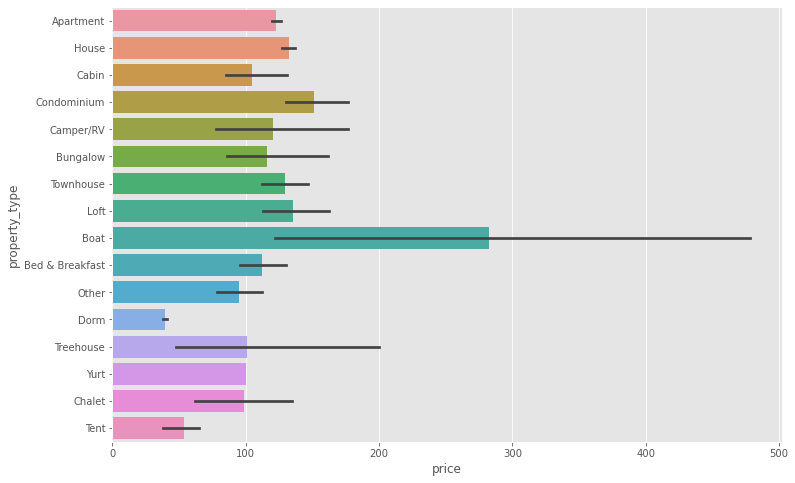

In [149]:
ax = sns.barplot(x="price", y="property_type", data=listings)

In [150]:
# merge levels
property_type = ['House', 'Apartment', 'Townhouse', 'Condominium', 'Loft', 'Boat']
listings['property_type'] = np.where(listings['property_type'].isin(property_type), listings['property_type'], 'Other')

In [151]:
listings['property_type'].value_counts()

House          1733
Apartment      1708
Other           120
Townhouse       118
Condominium      91
Loft             40
Boat              8
Name: property_type, dtype: int64

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Combine levels for property_type.
    </font>
</div>

In [132]:
listings['room_type'].value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [133]:
listings['bed_type'].value_counts()

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

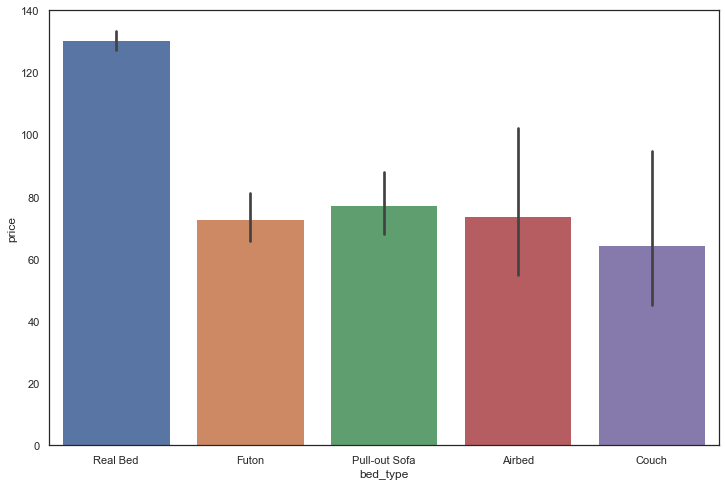

In [648]:
ax = sns.barplot(x="bed_type", y="price", data=listings)

In [153]:
# convert bed_type to boolean
listings['real_bed'] = np.where(listings['bed_type'] == 'Real Bed', 1, 0)

# drop 'bed_type'
listings.drop(columns=['bed_type'], inplace=True)

# sanity check
listings['real_bed'].value_counts()

1    3657
0     161
Name: real_bed, dtype: int64

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Convert 'bed_type' to boolean feature 'real_bed' and drop 'bed_type'.
    </font>
</div>

In [146]:
listings['experiences_offered'].value_counts()

none    3818
Name: experiences_offered, dtype: int64

In [167]:
col_drop.append('experiences_offered')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Drop experiences_offered due to invariant value.
    </font>
</div>

In [626]:
listings['accommodates'].value_counts()

2     1627
4      785
3      398
6      332
1      256
5      184
8      119
7       52
10      25
12      15
9       13
16       4
11       3
14       3
15       2
Name: accommodates, dtype: int64

In [627]:
# convert accommodates to numeric
listings['accommodates'] = listings['accommodates'].astype('int')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Convert accommodates from categorical to numeric.
    </font>
</div>

#### Boolean convert to 1/0

In [136]:
bool_var = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', \
            'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']

listings[bool_var] = listings[bool_var].replace({'t': 1, 'f': 0})

# sanity check
listings[bool_var].apply(pd.Series.value_counts)

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0.0,3038,7,819,406,3227,3497,3443
1.0,778,3809,2997,3412,591,321,375


In [158]:
# drop 'host_has_profile_pic'
listings.drop(columns=['host_has_profile_pic'], inplace=True)

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Convert t/f to 1/0 for boolean variable. Drop host_has_profile_pic due to no signal.
    </font>
</div>

#### Parse out amenities

In [189]:
listings['amenities'][:2].values

array(['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}',
       '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}'],
      dtype=object)

In [141]:
# clean and parse out each item in the list
listings["amenities"] = listings["amenities"].str.lower().replace('[{"}]', '', regex=True)  \
                                             .str.replace(' ','_')   \
                                             .str.split(',')
listings["amenities"].head()

0    [tv, cable_tv, internet, wireless_internet, ai...
1    [tv, internet, wireless_internet, kitchen, fre...
2    [tv, cable_tv, internet, wireless_internet, ai...
3    [internet, wireless_internet, kitchen, indoor_...
4    [tv, cable_tv, internet, wireless_internet, ki...
Name: amenities, dtype: object

In [219]:
# use MultiLabelBinarizer to obtain amenities matrix
mlb = MultiLabelBinarizer()
amenities_mat = pd.DataFrame(mlb.fit_transform(listings["amenities"]),
                             columns=mlb.classes_)

In [145]:
amenities_mat

,,24-hour_check-in,air_conditioning,breakfast,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,cat(s),dog(s),doorman,dryer,elevator_in_building,essentials,family/kid_friendly,fire_extinguisher,first_aid_kit,free_parking_on_premises,gym,hair_dryer,hangers,heating,hot_tub,indoor_fireplace,internet,iron,kitchen,laptop_friendly_workspace,lock_on_bedroom_door,other_pet(s),pets_allowed,pets_live_on_this_property,pool,safety_card,shampoo,smoke_detector,smoking_allowed,suitable_for_events,tv,washer,washer_/_dryer,wheelchair_accessible,wireless_internet
0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1
2,0,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1
3,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1
4,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0,0,1,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1
3814,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
3815,0,0,0,1,0,1,0,1,1,0,1,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1
3816,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Parsed out amenities column and explode to be a binary matrix with each amenity being one column.
    </font>
</div>

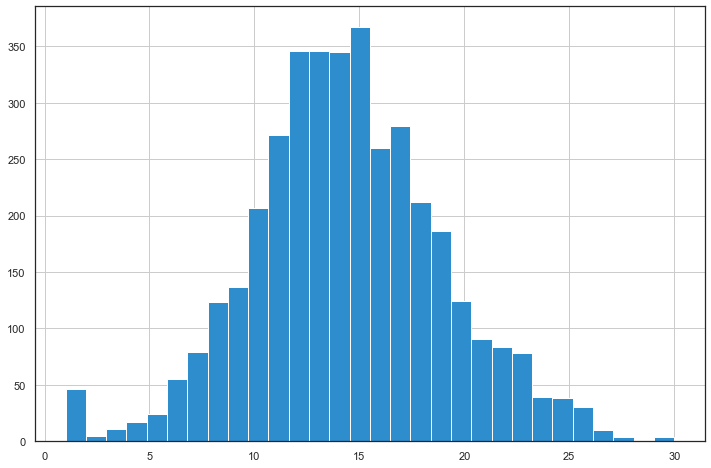

In [221]:
# check distribution of number of amenities
amenities_mat.sum(axis = 1).hist(bins = 30, color = '#2e8dcc');

In [222]:
# check correlation of number of amenities with price
amenities_mat.sum(axis = 1).corr(listings['price'])

0.18417581916964434

In [227]:
# add number of amenities by listing to the main df
listings = pd.concat([listings, pd.DataFrame(amenities_mat.sum(axis = 1), columns = ['num_amenities'])], axis=1)

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Add number of amenities by listing to the main df because there is a decent amount of correlation (0.18)
    </font>
</div>

In [180]:
# check amenity fequency among all listings
amenities_mat.sum().sort_values(ascending=False)

wireless_internet             3667
heating                       3627
kitchen                       3423
smoke_detector                3281
essentials                    3237
dryer                         2997
washer                        2992
internet                      2811
shampoo                       2670
tv                            2574
carbon_monoxide_detector      2485
fire_extinguisher             2196
free_parking_on_premises      2167
family/kid_friendly           1963
first_aid_kit                 1680
cable_tv                      1446
indoor_fireplace               886
pets_live_on_this_property     883
hangers                        846
elevator_in_building           785
hair_dryer                     774
laptop_friendly_workspace      745
iron                           742
safety_card                    727
air_conditioning               677
24-hour_check-in               616
buzzer/wireless_intercom       538
dog(s)                         509
pets_allowed        

In [181]:
# concatenate price to amenities_mat and calculate correlation
amenities_mat = pd.concat([amenities_mat, listings['price']], axis=1)

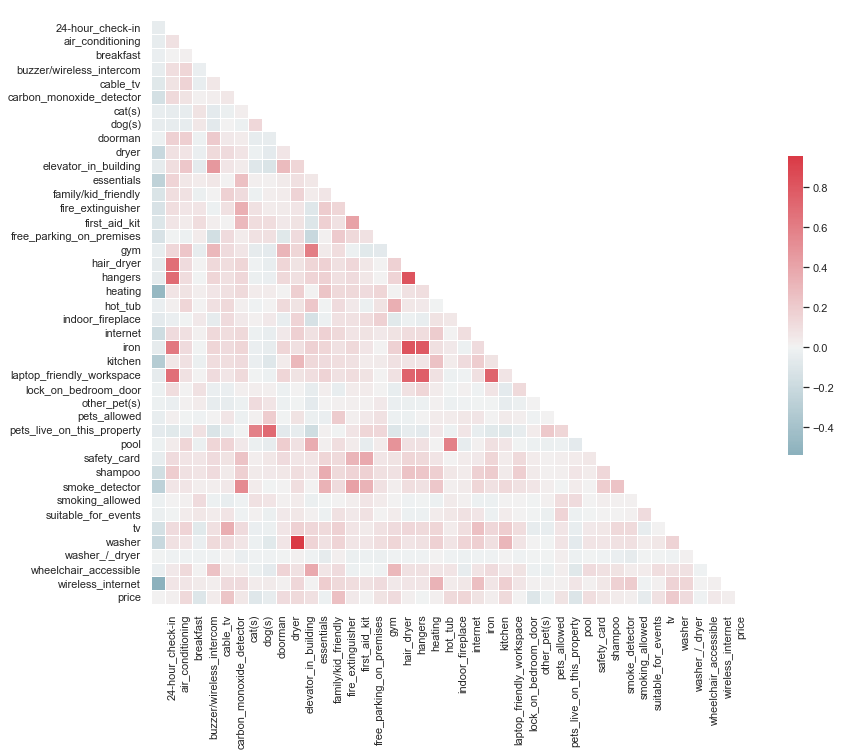

In [183]:
# correlation heatmap
correlation_heatmap(amenities_mat)

In [206]:
corr = amenities_mat.corr()[['price']].sort_values(by='price', ascending=False)
corr.columns = ['Correlation_with_price']

# amenity frequency sort by correlation with price
amenity_smry = pd.merge(pd.DataFrame(amenities_mat.sum(), columns = ['Frequency']), corr[1:], left_index=True, right_index=True) \
  .sort_values(by='Correlation_with_price', ascending=False)
amenity_smry

,Frequency,Correlation_with_price
family/kid_friendly,1963.0,0.259901
cable_tv,1446.0,0.237309
tv,2574.0,0.205824
indoor_fireplace,886.0,0.148466
air_conditioning,677.0,0.130271
hot_tub,303.0,0.127066
kitchen,3423.0,0.125024
dryer,2997.0,0.124589
washer,2992.0,0.120973
doorman,85.0,0.120872


In [210]:
# select top amenities and most negative amenity
amenity_data = amenities_mat[amenity_smry.query('Correlation_with_price > 0.09 or Correlation_with_price < -0.11').index.to_list()]
amenity_data.head()

,family/kid_friendly,cable_tv,tv,indoor_fireplace,air_conditioning,hot_tub,kitchen,dryer,washer,doorman,gym,pool,elevator_in_building,pets_live_on_this_property
0,1,1,1,0,1,0,1,1,1,0,0,0,0,0
1,1,0,1,0,0,0,1,1,1,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,0,0,0,0,1
3,1,0,0,1,0,0,1,1,1,0,0,0,0,0
4,1,1,1,0,0,0,1,0,0,0,0,0,0,0


In [258]:
# append amenity data to main listings data
listings = pd.concat([listings, amenity_data], axis=1)


<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Add important amenities matrix to listing data.
    </font>
</div>

#### Numeric features

In [55]:
# Basic statistics for numeric features
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


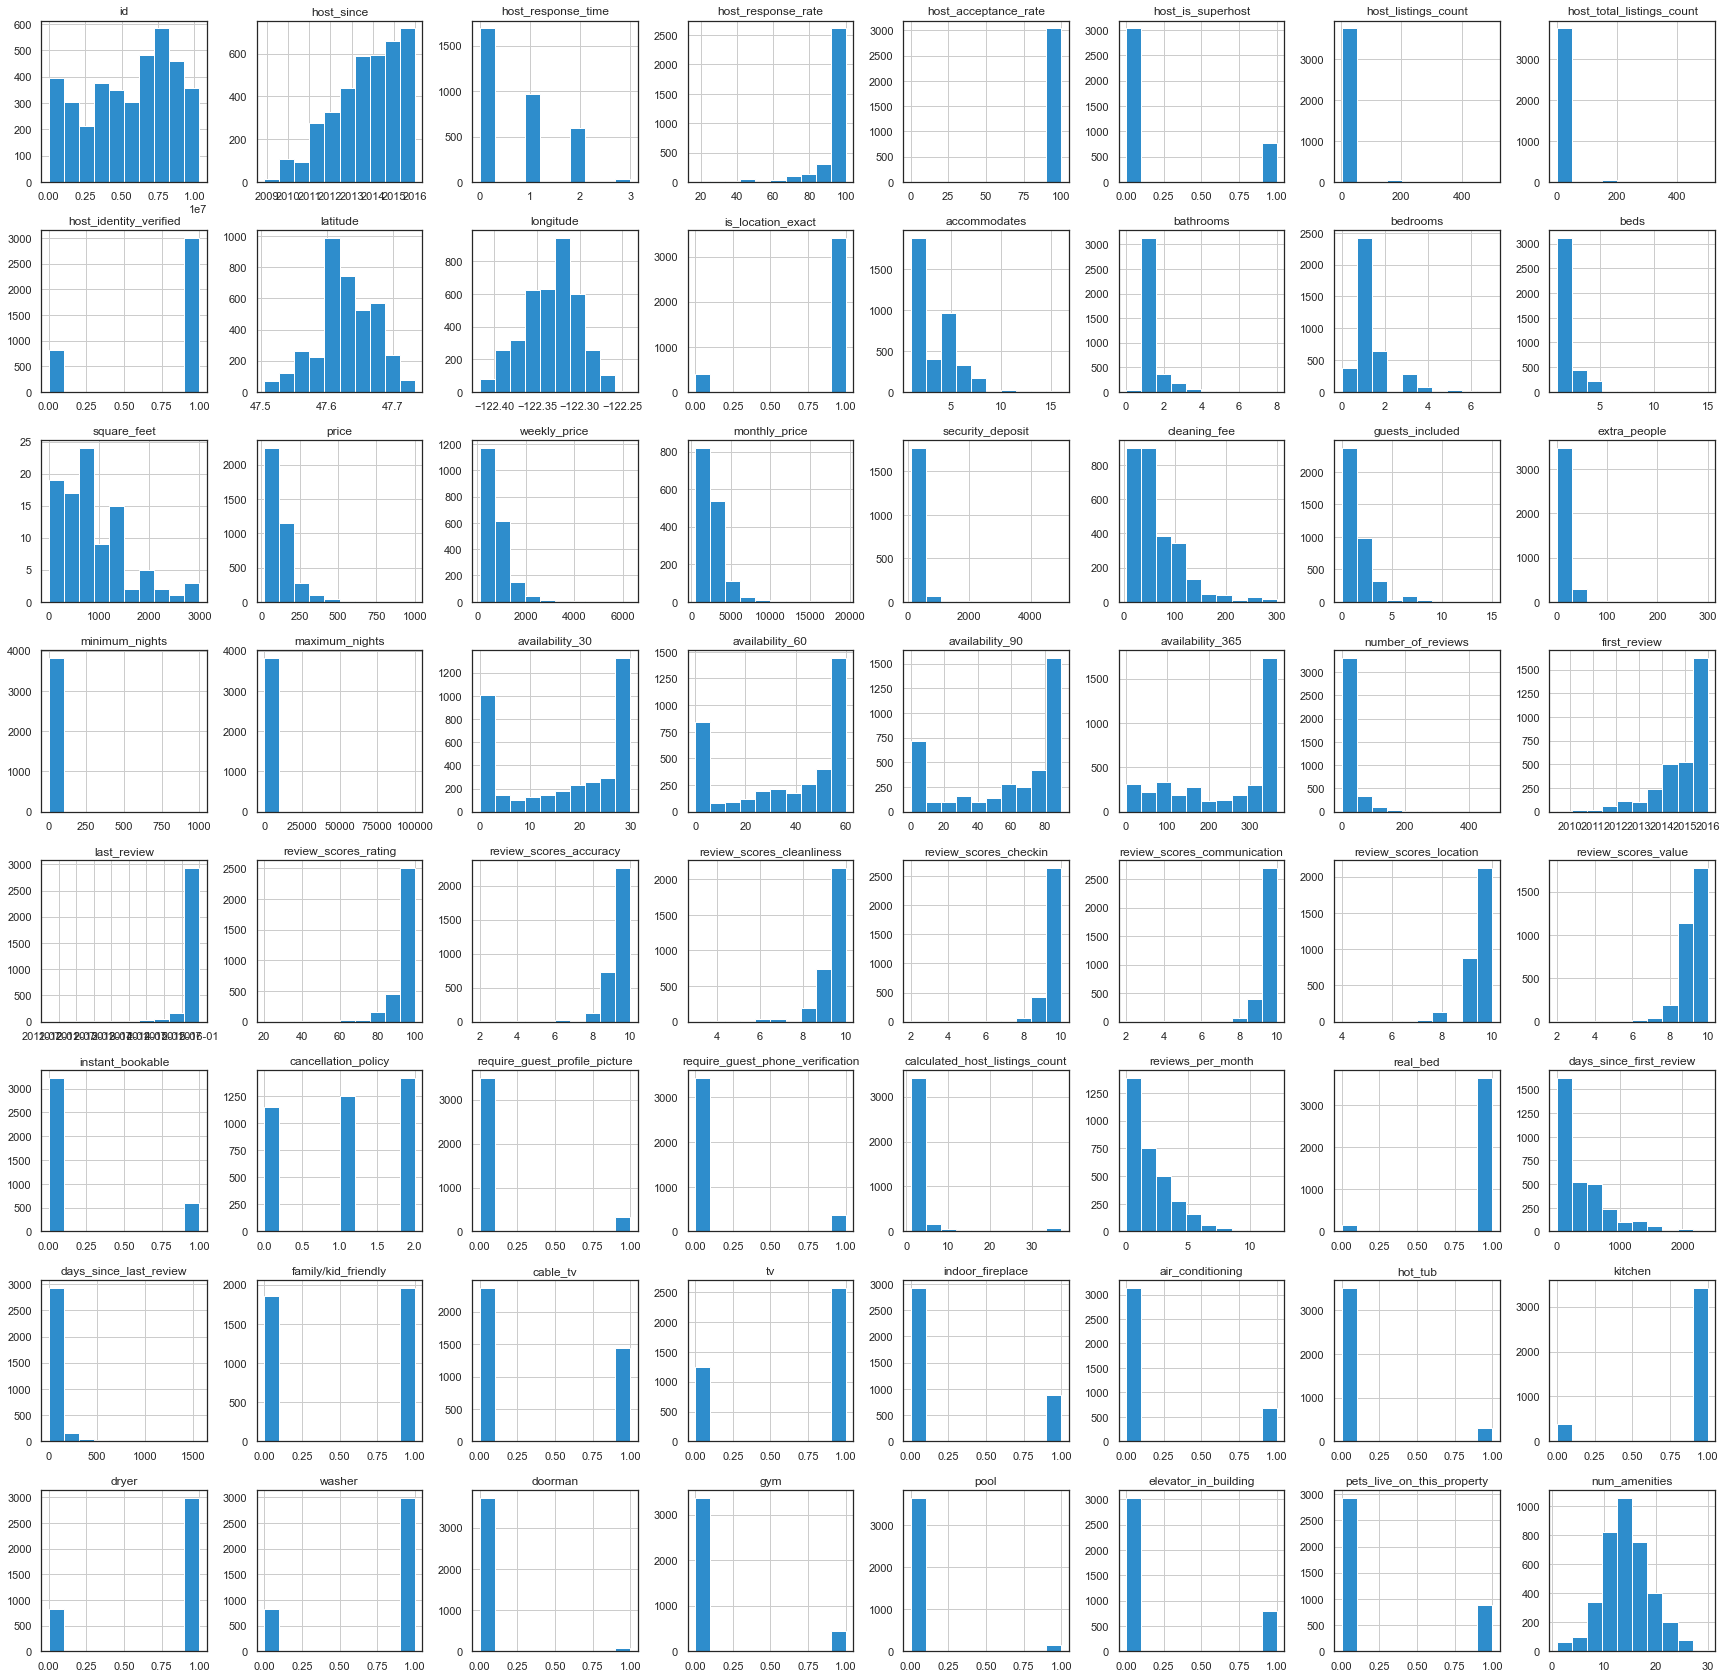

In [233]:
listings.drop(columns=col_drop).hist(figsize=(30,30), color = '#2e8dcc');

**Review ratings features**

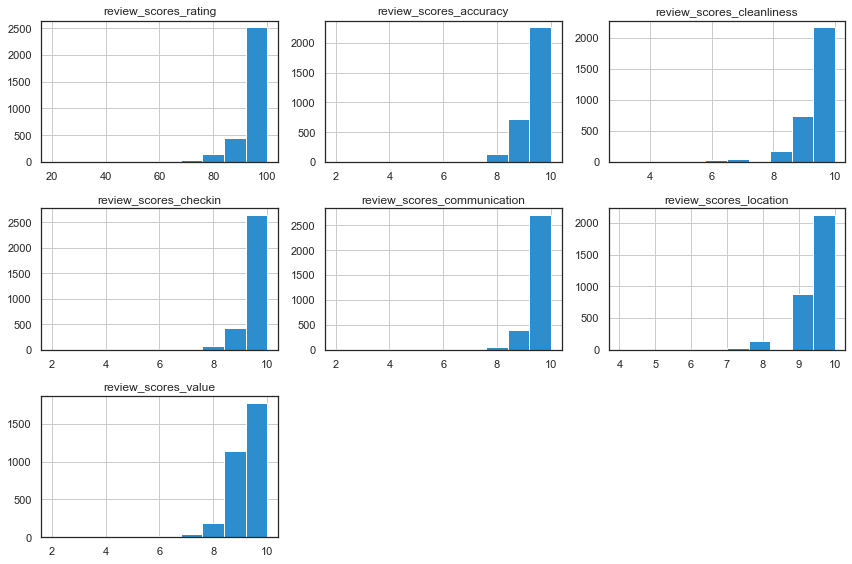

In [649]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(listings.columns[listings.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))

for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3, 3, i+1)
    listings[var_name].hist(bins=10, ax=ax, color = '#2e8dcc')
    ax.set_title(var_name)
    
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        The histograms above show that the majority of ratings are 9 or 10 out of 10, or > 90 for review_scores_ratings. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating). Listings without reviews will be kept and replaced with 'no reviews'. 
    </font>
</div>

In [281]:
# create function to bin numeric features
def bin_column(df, col, bins, labels, na_label='no reviews'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].replace('nan', na_label, inplace=True)

In [650]:
# Binning for all columns scored out of 10
for col in variables_to_plot[1:]:
    bin_column(listings, col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [651]:
# Binning column scored out of 100
bin_column(listings, 'review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-80/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [284]:
# sanity check
listings['review_scores_rating'].value_counts()

95-100/100    1763
80-94/100     1227
no reviews     647
<80/100        181
Name: review_scores_rating, dtype: int64

In [285]:
# sanity check
listings['review_scores_accuracy'].value_counts()

10/10         2261
9/10           730
no reviews     658
<=8/10         169
Name: review_scores_accuracy, dtype: int64

**Host listings count**

In [297]:
list_cnt_var = list(listings.columns[listings.columns.str.endswith("listings_count") == True])

# check missing pct
df_list_missing[df_list_missing.index.isin(list_cnt_var)]

,missing_rate
host_listings_count,0.000524
host_total_listings_count,0.000524
calculated_host_listings_count,0.000000


In [304]:
# check correlation
listings[list_cnt_var].corr()

,host_listings_count,host_total_listings_count,calculated_host_listings_count
host_listings_count,1.000000,1.000000,0.224222
host_total_listings_count,1.000000,1.000000,0.224222
calculated_host_listings_count,0.224222,0.224222,1.000000


In [ ]:
# keep host_listings_count and drop two others
col_drop.extend(['host_total_listings_count', 'calculated_host_listings_count'])

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Drop the two other listing_count columns as they are highly correlated with host_listings_count.
    </font>
</div>

**Host response rate**

<AxesSubplot:>

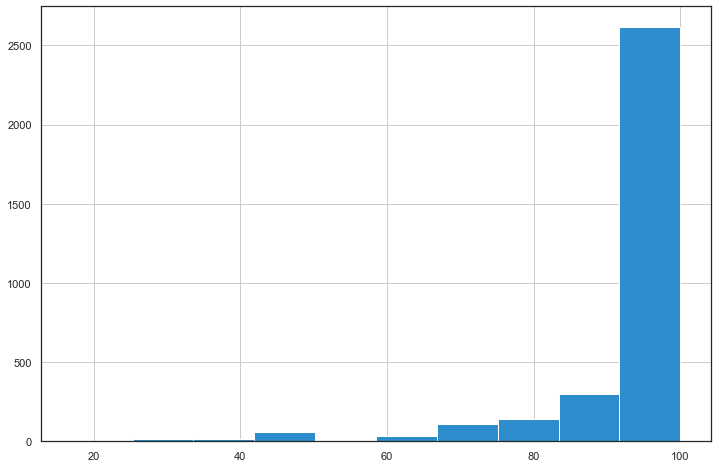

In [324]:
listings['host_response_rate'].hist(bins = 10, color = '#2e8dcc')

In [325]:
# binning for host_response_rate
bin_column(listings, 'host_response_rate',
           bins=[0, 80, 95, 100],
           labels=['0-80/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [326]:
# sanity check
listings['host_response_rate'].value_counts()

95-100/100    2526
no reviews     523
80-94/100      414
<80/100        355
Name: host_response_rate, dtype: int64

**Latitude and longitude**

In [ ]:
# drop latitude and longitude
col_drop.extend(['latitude', 'longitude'])

<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps: </b> 
        Get coordinates of famous attractions like space needle, airplanes, etc. and calculate manhattan distance between them and each listing location as new features. 
    </font>
</div>

**Numeric feature with high missing%**

In [38]:
# check missing pct for all numeric var
df_high_miss_num = df_list_missing[df_list_missing.index.isin(listings.select_dtypes(include=np.number).columns.tolist())]
df_high_miss_num

,missing_rate
license,1.000000
square_feet,0.974594
monthly_price,0.602672
security_deposit,0.511262
weekly_price,0.473808
cleaning_fee,0.269775
host_acceptance_rate,0.202462
reviews_per_month,0.164222
bathrooms,0.004191
bedrooms,0.001572


<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Before missing imputation, add additional features to flag missing variables. As we don't know what caused the missing, we want to flag them out and see if model can pick up any signal.
    </font>
</div>

In [39]:
# create features to flag out missing values for high missing features
missing_num_var = df_high_miss_num.query("missing_rate > 0.1 and missing_rate < 1").index.to_list()

df_miss_num_flags = pd.DataFrame(listings[missing_num_var].isna().astype(int))
df_miss_num_flags.columns = ['miss_' + col for col in missing_num_var]

df_miss_num_flags.head()

,miss_square_feet,miss_monthly_price,miss_security_deposit,miss_weekly_price,miss_cleaning_fee,miss_host_acceptance_rate,miss_reviews_per_month
0,1,1,1,1,1,0,0
1,1,0,0,0,0,0,0
2,1,1,0,1,0,0,0
3,1,0,1,0,1,1,1
4,1,1,0,1,0,1,0


In [341]:
# append df_miss_num_flags data to main listings data
listings = pd.concat([listings, df_miss_num_flags], axis=1)

 * Square feet

<AxesSubplot:>

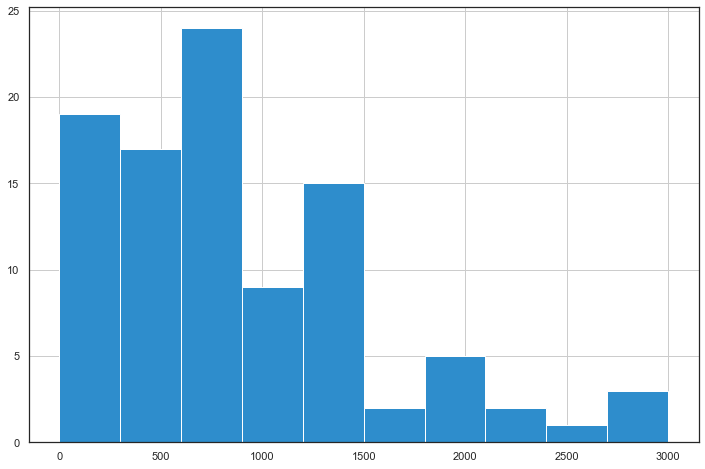

In [329]:
listings['square_feet'].hist(bins = 10, color = '#2e8dcc')

In [342]:
# correlation of square feet, bedrooms, beds and accommodates
listings.loc[listings['square_feet'].notna(), ['square_feet', 'beds', 'bedrooms', 'bathrooms', 'accommodates']].corr()

,square_feet,beds,bedrooms,bathrooms,accommodates
square_feet,1.000000,0.312155,0.448786,0.381094,0.439057
beds,0.312155,1.000000,0.742920,0.303472,0.847347
bedrooms,0.448786,0.742920,1.000000,0.418992,0.819337
bathrooms,0.381094,0.303472,0.418992,1.000000,0.331858
accommodates,0.439057,0.847347,0.819337,0.331858,1.000000


In [ ]:
# drop square_feet
col_drop.append('square_feet')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Drop square_feet due to 97% missing and part of the signal could be obtained from bedrooms and accommodates.
    </font>
</div>

<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps: </b> 
        Use NLP to extract square feet data from description, summary, space column.
    </font>
</div>

* monthly and weekly price

In [343]:
# correlation of different price
listings.loc[listings['monthly_price'].notna(), ['monthly_price', 'weekly_price', 'price', 'bedrooms', 'accommodates']].corr()

,monthly_price,weekly_price,price,bedrooms,accommodates
monthly_price,1.000000,0.942644,0.873450,0.568478,0.624997
weekly_price,0.942644,1.000000,0.932105,0.581564,0.635608
price,0.873450,0.932105,1.000000,0.604761,0.637203
bedrooms,0.568478,0.581564,0.604761,1.000000,0.736881
accommodates,0.624997,0.635608,0.637203,0.736881,1.000000


In [344]:
# impute monthly and weekly price with median
for col in ['monthly_price', 'weekly_price']:
    listings[col].fillna(listings[col].median(), inplace=True)

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Impute monthly and weekly price with median. Not imputing with group median due to high missing %.
    </font>
</div>

* Security deposit and cleaning fee

In [346]:
# impute security deposit and cleaning fee with 0
for col in ['security_deposit', 'cleaning_fee']:
    listings[col].fillna(0, inplace=True)

In [362]:
# sanity check
listings[['security_deposit', 'cleaning_fee']].isna().sum()

security_deposit    0
cleaning_fee        0
dtype: int64

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Having a missing value for security deposit or cleaning fee can be seen equivalent to having a security deposit or fee of 0, so missing values will be replaced with 0.
    </font>
</div>

* reviews per month

In [350]:
# correlation of reviews_per_month and number_of_reviews
listings.loc[listings['reviews_per_month'].notna(), ['reviews_per_month', 'number_of_reviews']].corr()

,reviews_per_month,number_of_reviews
reviews_per_month,1.000000,0.561438
number_of_reviews,0.561438,1.000000


<AxesSubplot:>

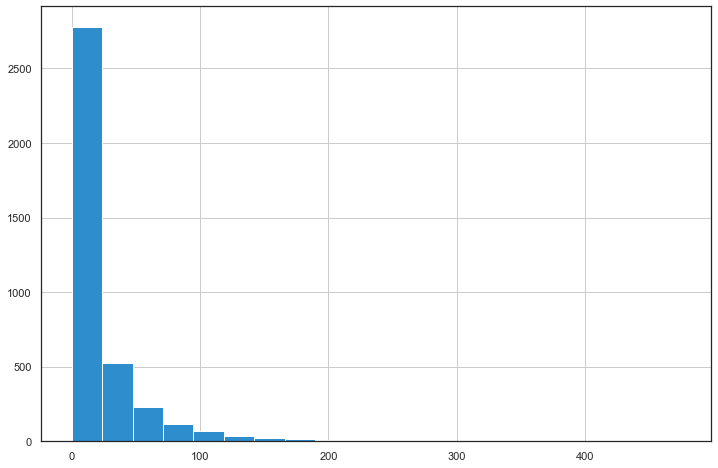

In [352]:
listings['number_of_reviews'].hist(bins = 20, color = '#2e8dcc')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        In feature engineering section, I will create a feature host_days_tenure. Then, we can use number_of_reviews/(host_days_tenure/30) to calculate reviews_per_month and impute if original reviews_per_month column is missing.
    </font>
</div>

* host_response_time

In [355]:
listings['host_response_time'].value_counts()

0.0    1692
1.0     968
2.0     597
3.0      38
Name: host_response_time, dtype: int64

In [356]:
# impute missing with median
listings['host_response_time'].fillna(listings['host_response_time'].median(), inplace=True)

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Impute host_response_time missing with median
    </font>
</div>

#### Text features

In [242]:
text_var = ['name', 'description', 'street', 'summary', 'space', 'neighborhood_overview', 'notes', 'transit', 'host_about']

In [243]:
# check missing pct
df_list_missing[df_list_missing.index.isin(text_var)]

,missing_rate
notes,0.420639
neighborhood_overview,0.270299
transit,0.244631
host_about,0.224987
space,0.149031
summary,0.046359
name,0.000000
description,0.000000
street,0.000000


In [ ]:
# drop street 
col_drop.append('street')

<div class="alert alert-block alert-success">
    <font color=black><b>Cleaning: </b> 
        Drop street because it introduces too much noise in this rather small dataset and we already have zipcode and neighbourhood data.
    </font>
</div>

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        For the sake of time, we will only engineer <b>name</b>  and <b>description</b> feature in the feature engineering section and convert other text features as boolean, indicating whether or not this information was provided by the host.
    </font>
</div>

In [250]:
has_info = listings[text_var[3:]].notnull().astype(int)
has_info.head()

,summary,space,neighborhood_overview,notes,transit,host_about
0,0,1,0,0,0,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,0,0,0,0,0
4,1,1,1,1,1,1


In [254]:
df_has_info = pd.DataFrame(has_info)
df_has_info.columns = ['has_' + col for col in text_var[3:]]
df_has_info.head()

,has_summary,has_space,has_neighborhood_overview,has_notes,has_transit,has_host_about
0,0,1,0,0,0,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,0,0,0,0,0
4,1,1,1,1,1,1


In [255]:
# drop original columns and append new features to listings
col_drop.extend(text_var[3:])

In [257]:
# append has_info data to main listings data
listings = pd.concat([listings, df_has_info], axis=1)


<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps: </b> 
        Use NLP techniques on all text features to extract potential useful signal.
    </font>
</div>

# Question 2:  Exploratory Data Analysis
1. Given your objective,  explore your data. Present valuable insights coming from the dataset.
* Present insights regarding the price


## Calendar data

### Price fluctuation over time

In [570]:
# parse month, day_of_mth, day_name from date
calendar['month'] = calendar['date'].dt.month
calendar['day_of_mth'] = calendar['date'].dt.day
calendar['day_name'] = calendar['date'].dt.day_name()

In [541]:
calendar.head(10)

,listing_id,date,available,price,month,day_of_mth,day_name
0,241032,2016-01-04,t,85.0,1,4,Monday
1,241032,2016-01-05,t,85.0,1,5,Tuesday
2,241032,2016-01-06,f,NaN,1,6,Wednesday
3,241032,2016-01-07,f,NaN,1,7,Thursday
4,241032,2016-01-08,f,NaN,1,8,Friday
5,241032,2016-01-09,f,NaN,1,9,Saturday
6,241032,2016-01-10,f,NaN,1,10,Sunday
7,241032,2016-01-11,f,NaN,1,11,Monday
8,241032,2016-01-12,f,NaN,1,12,Tuesday
9,241032,2016-01-13,t,85.0,1,13,Wednesday


[Text(0.5, 1.0, 'Avg listing price by date')]

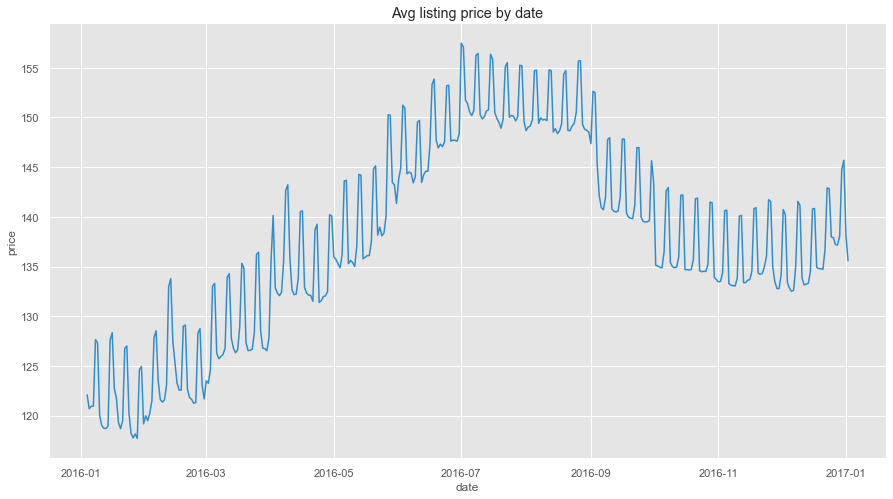

In [550]:
# explore price seasonality
calendar_day = calendar.groupby('date')['price'].mean()
calendar_day = pd.DataFrame(calendar_day).reset_index()

# plot daily price
plt.rcParams['figure.figsize'] = [15, 8]
sns.lineplot(x='date', 
             y='price',
             data=calendar_day,
             color='#2e8dcc')    \
   .set(title='Avg listing price by date')


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        <li>Strong monthly trend - higher price/demand in summer, off season in spring. </li>
        <li>Strong seasonality within each month. </li>
    </font>
</div>

In [546]:
month_avg_price = calendar.groupby('month')['price'].mean()
month_avg_price = pd.DataFrame(month_avg_price).reset_index()
month_avg_price.columns = ['month', 'avg_price']
month_avg_price

,month,avg_price
0,1,122.912176
1,2,124.293927
2,3,128.644488
3,4,135.097005
4,5,139.538183
5,6,147.473137
6,7,152.094150
7,8,150.656594
8,9,143.255949
9,10,137.031939


[Text(0.5, 1.0, 'Avg listing price by month')]

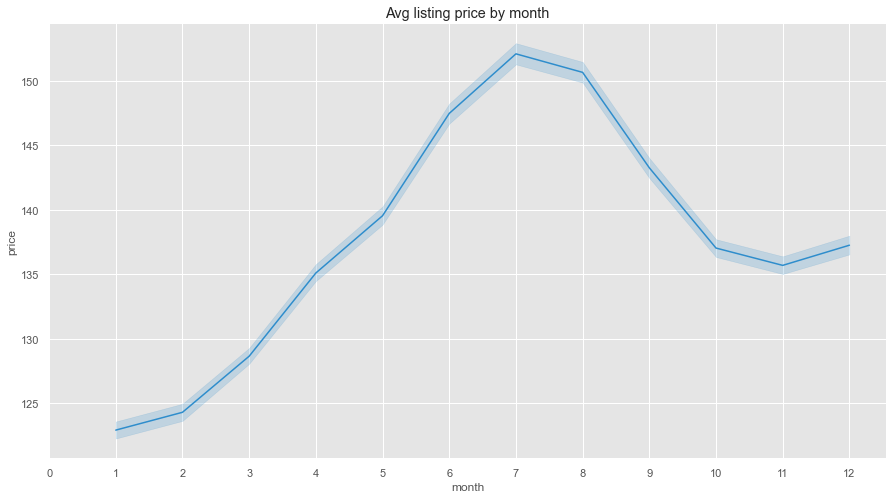

In [553]:
# plot monthly price variation
ax = sns.lineplot(x="month", y="price", data=calendar, color='#2e8dcc')
ax.set_xticks(range(13))
ax.set(title='Avg listing price by month')

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        <li>Strong monthly trend - higher price/demand in summer, off season in spring. </li>
    </font>
</div>

<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps: </b> 
        Collect exogenous data points which tend to correlate with season/month, such as weather in Seattle (temperature, precipitation, sunny/cloudy), historical average visitors volume, average hotel price, etc.
    </font>
</div>

[Text(0.5, 1.0, 'Avg listing price by day_of_mth')]

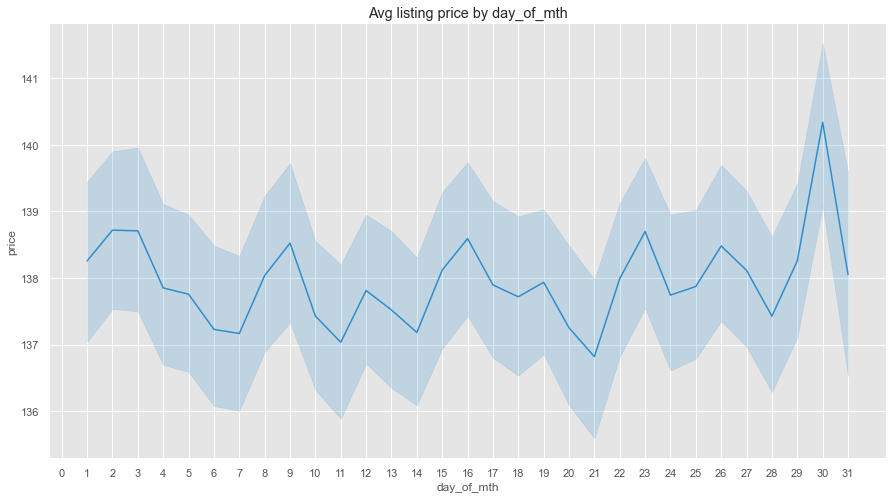

In [556]:
# plot price variation by day_of_mth
ax = sns.lineplot(x="day_of_mth", y="price", data=calendar, color='#2e8dcc')
ax.set_xticks(range(32))
ax.set(title='Avg listing price by day_of_mth')

[Text(0.5, 1.0, 'Avg listing price by day_name')]

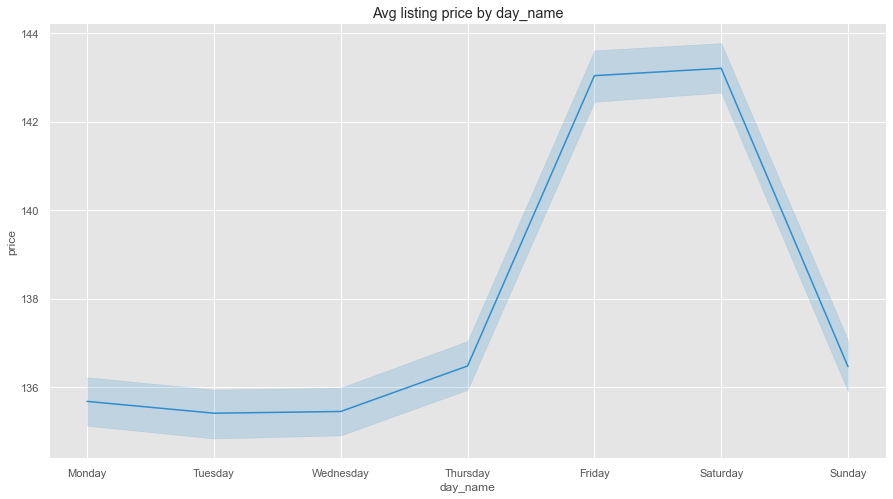

In [557]:
# plot price variation by day_of_mth
ax = sns.lineplot(x="day_name", y="price", data=calendar, color='#2e8dcc')
#ax.set_xticks(range(32))
ax.set(title='Avg listing price by day_name')

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        <li>Strong weekday trend - higher price/demand on Friday and Saturday. </li>
    </font>
</div>

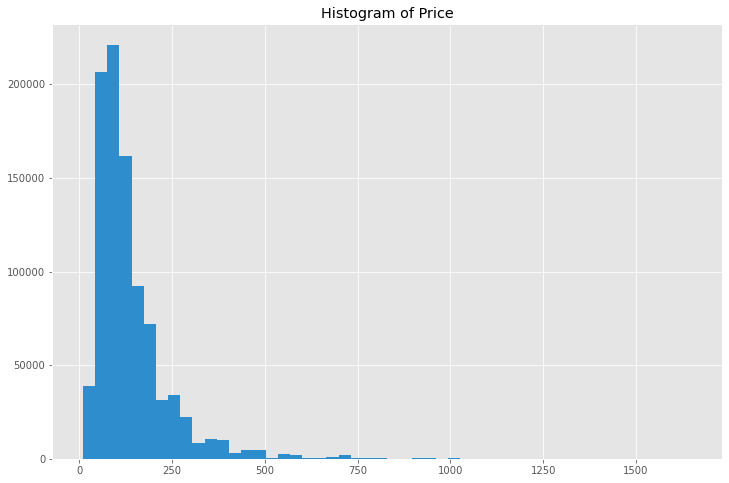

In [37]:
# plot histogram for price across full date range and listing
plt.hist(calendar[calendar['price'].notna()]['price'], 50, density=False, color='#2e8dcc')
plt.title('Histogram of Price')
plt.show()

<AxesSubplot:xlabel='price'>

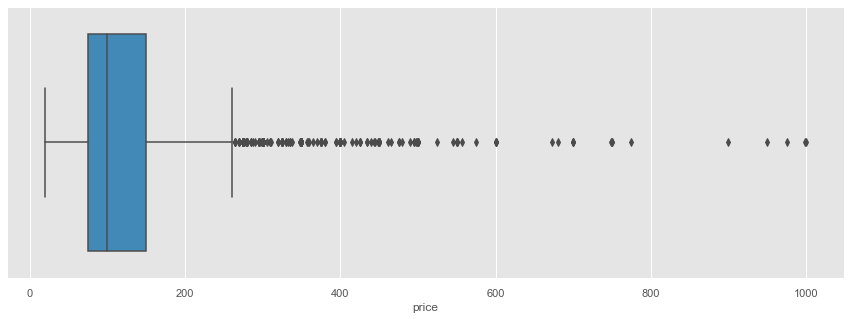

In [561]:
plt.rcParams['figure.figsize'] = [15, 5]
sns.boxplot(x="price", data=listings, color='#2e8dcc')

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Listing price is higly right skewed and there are lots of outliers.
    </font>
</div>

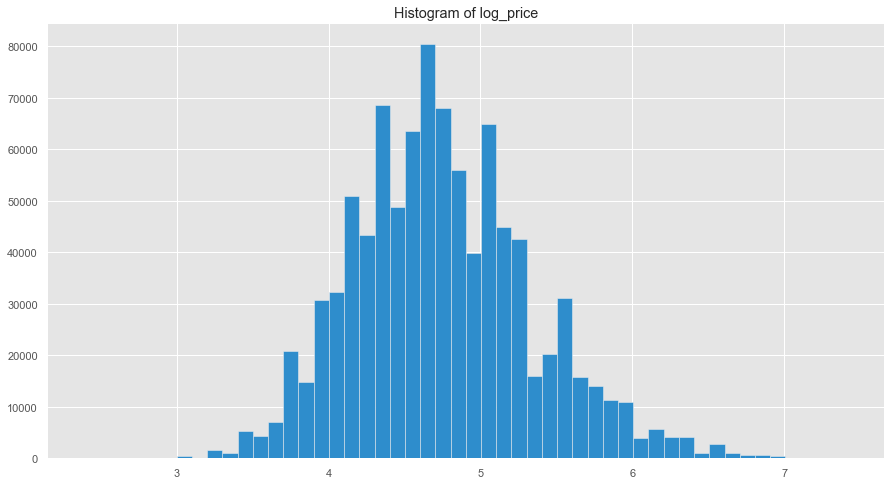

In [559]:
# plot log(price)
plt.hist(np.log(calendar[calendar['price'].notna()]['price']+1), 50, density=False, color='#2e8dcc')
plt.title('Histogram of log_price')
plt.show()

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        The distribution of the log_price looks much more like normal distribution. We might try to use log_price as target instead of raw price. This can help mitigate the impact of outliers in price.
    </font>
</div>

In [43]:
# calculate price standard deviation by listing
df_price_std = calendar.groupby('listing_id')['price'].std().reset_index()
df_price_std.columns = ['listing_id', 'price_std']

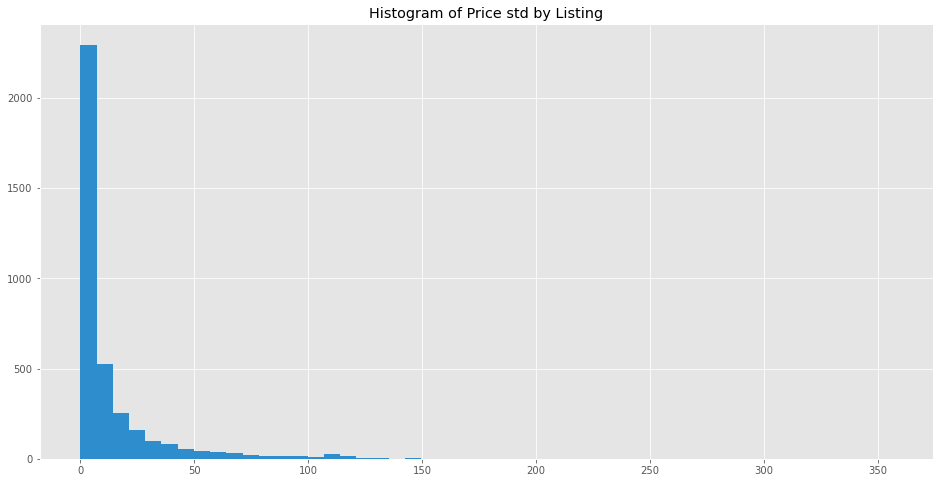

In [31]:
# plot histogram for price std by listing
plt.hist(df_price_std['price_std'], 50, density=False, color='#2e8dcc')
plt.title('Histogram of Price std by Listing')
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

In [54]:
# pct of listings with flat price (time invariant)
print(f"pct of listings with flat price over time:\
      {df_price_std.query('price_std == 0').shape[0] / len(df_price_std) :.1%}"
     )

pct of listings with flat price over time:      41.9%


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Std of price over date by listing is also higly right skewed, meaning there was a great amount of seasonality being factored in some listing price. But do note that there are ~42% of listings with fix price over data range which makes them time invariant.
    </font>
</div>

In [582]:
# listings with fix price
fix_price_listing_id = df_price_std.loc[df_price_std['price_std']==0, 'listing_id']

# filter out listings with invariant price
fix_price_calendar = calendar.loc[calendar['listing_id'].isin(fix_price_listing_id)]

In [599]:
# sanity check
fix_price_calendar.groupby('listing_id')['price'].nunique().nunique()

1

#### Explore what listings tend to have fix price

In [607]:
# create fix_price flag
df_price_std['fix_price'] = np.where(df_price_std['price_std']==0, 1, 0)

# merge it to main data
listings = pd.merge(listings, df_price_std[['listing_id', 'fix_price']], how='left', left_on='id', right_on='listing_id')

In [186]:
df_price_std['fix_price'].value_counts()

0    2217
1    1601
Name: fix_price, dtype: int64

<AxesSubplot:xlabel='fix_price', ylabel='count'>

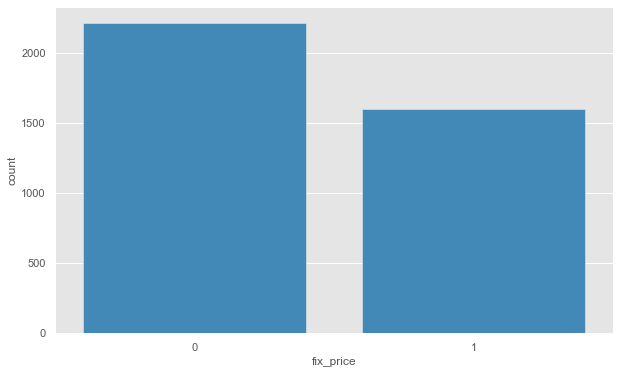

In [188]:
sns.countplot(x="fix_price", data=df_price_std, color='#2e8dcc')

In [611]:
# calculate correlation with fix_price
corr = listings.corr()[['fix_price']].sort_values(by='fix_price', ascending=False)
corr.columns = ['Correlation_with_fix_price']

In [612]:
corr.query("abs(Correlation_with_fix_price) > 0.1")

,Correlation_with_fix_price
fix_price,1.000000
miss_cleaning_fee,0.300278
miss_host_acceptance_rate,0.271921
miss_host_response_time,0.248067
miss_reviews_per_month,0.213590
miss_security_deposit,0.175702
days_since_last_review,0.122326
host_response_time,0.107507
availability_60,-0.102032
host_listings_count,-0.102551


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        <li>Listings with missing information (cleaning fee, security deposit, host hotes, space descriptions, etc.) tend to have fix price.</li>
        <li><b>Hypothesis: missing information of listings reflects low listing quality or low host engagement.</b></li>
        <li>Based on the assumption, fix price might because host set up a default price for the listing.</li>
    </font>
</div>

In [618]:
# import image module
from IPython.display import Image
  
# insert the screenshot from airbnb website regarding default price vs smart price
Image(url="Default price vs Smart price.png", width=700, height=700)

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
      <li>Since 42% of listings have fix price (price not changing across calendar date), we can't simply build a time series model or apply the same model training process to all listings especially when deriving time-related seasonality features.</li>
      <li>Therefore, we can consider first build a model to predict price for all listings on snapshot date (2016-01-04). Then build another model to identify fix price listings and apply their predicted price to all following dates in the calendar.</li>
    </font>
</div>

<AxesSubplot:xlabel='fix_price', ylabel='host_days_tenure'>

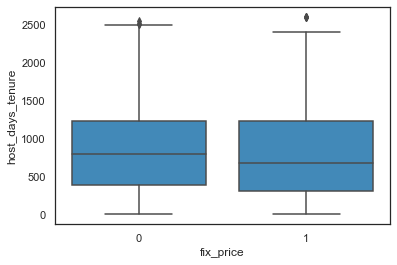

In [65]:
# host_days_tenure vs fix_price
sns.boxplot(x="fix_price", y="host_days_tenure", data=listings_2, color='#2e8dcc')

<AxesSubplot:xlabel='fix_price', ylabel='availability_365'>

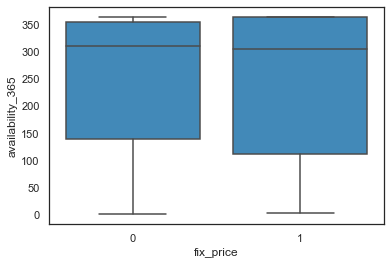

In [71]:
# availability_365 vs fix_price
sns.boxplot(x="fix_price", y="availability_365", data=listings_2, color='#2e8dcc')

### Price by listings attributes

**number of bedrooms**

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

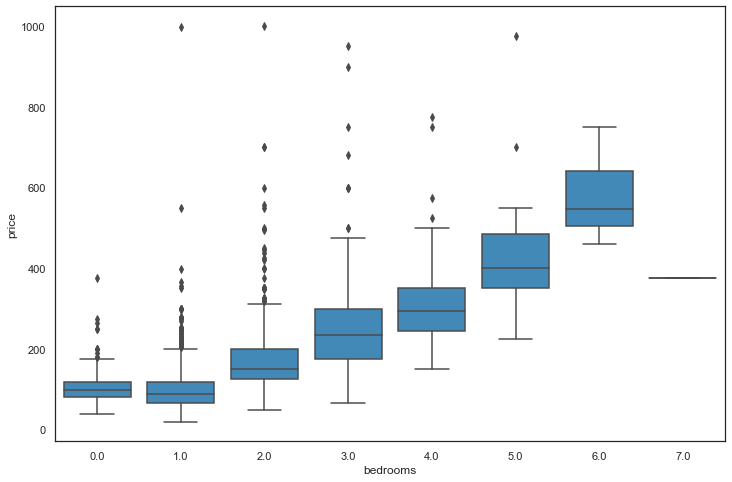

In [621]:
sns.boxplot(x="bedrooms", y="price", data=listings, color='#2e8dcc')

**number of bathrooms**

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

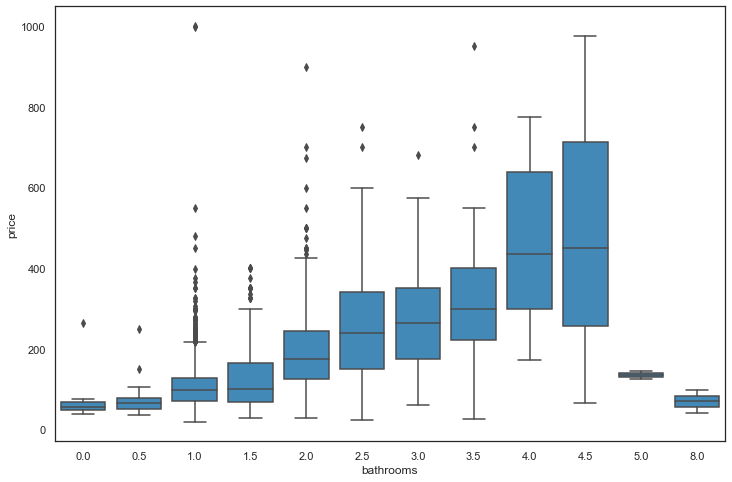

In [620]:
sns.boxplot(x="bathrooms", y="price", data=listings, color='#2e8dcc')

**accommodations**

<AxesSubplot:xlabel='accommodates', ylabel='price'>

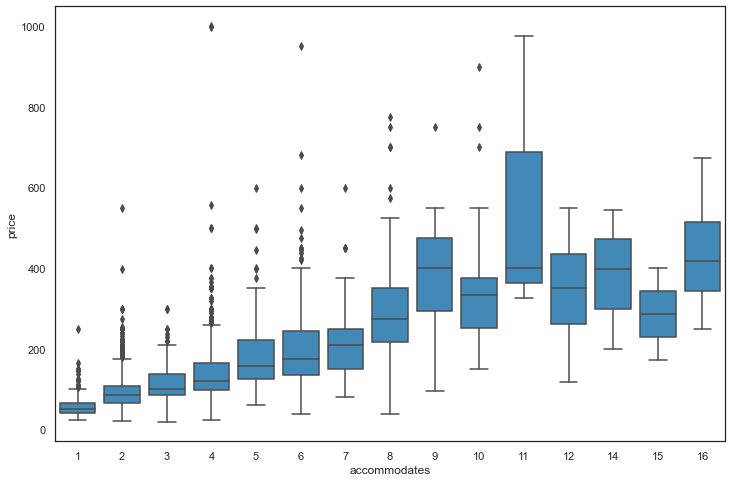

In [632]:
sns.boxplot(x="accommodates", y="price", data=listings, color='#2e8dcc')

**Property and room type**

<AxesSubplot:xlabel='property_type', ylabel='price'>

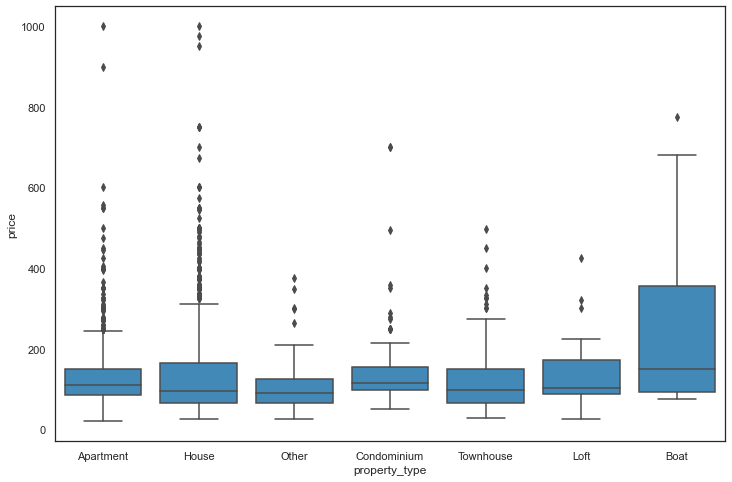

In [637]:
# property_type vs price
sns.boxplot(x="property_type", y="price", data=listings, color='#2e8dcc')

<AxesSubplot:xlabel='room_type', ylabel='price'>

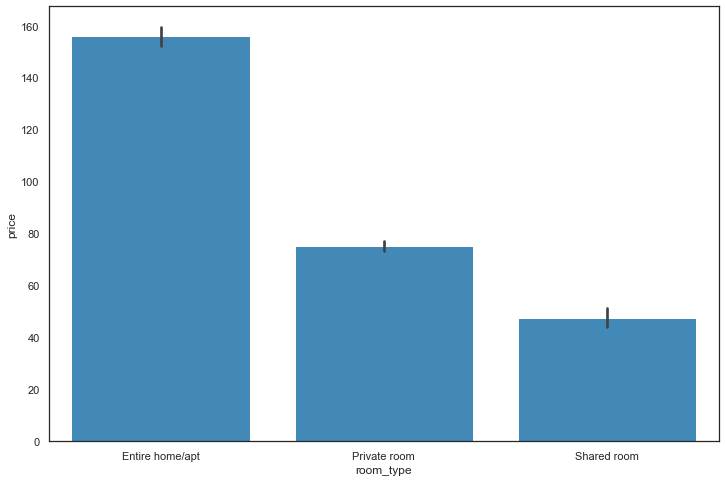

In [639]:
# room_type vs price
sns.barplot(x="room_type", y="price", data=listings, color='#2e8dcc')

**number of amenities**

<AxesSubplot:xlabel='num_amenities', ylabel='price'>

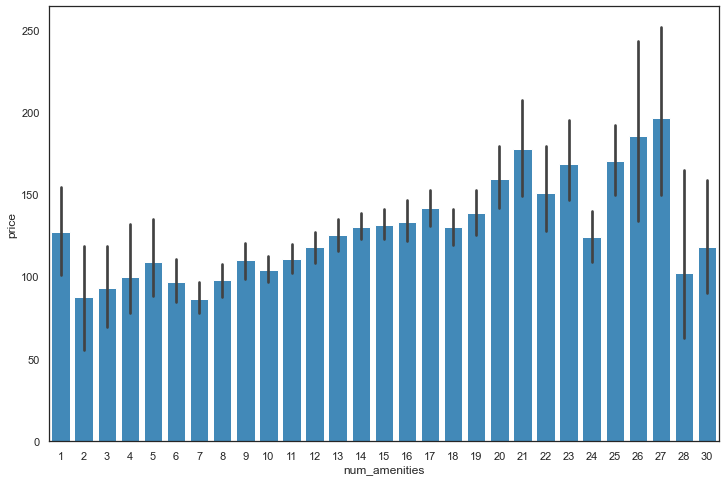

In [635]:
sns.barplot(x="num_amenities", y="price", data=listings, color='#2e8dcc')

**Amenities**

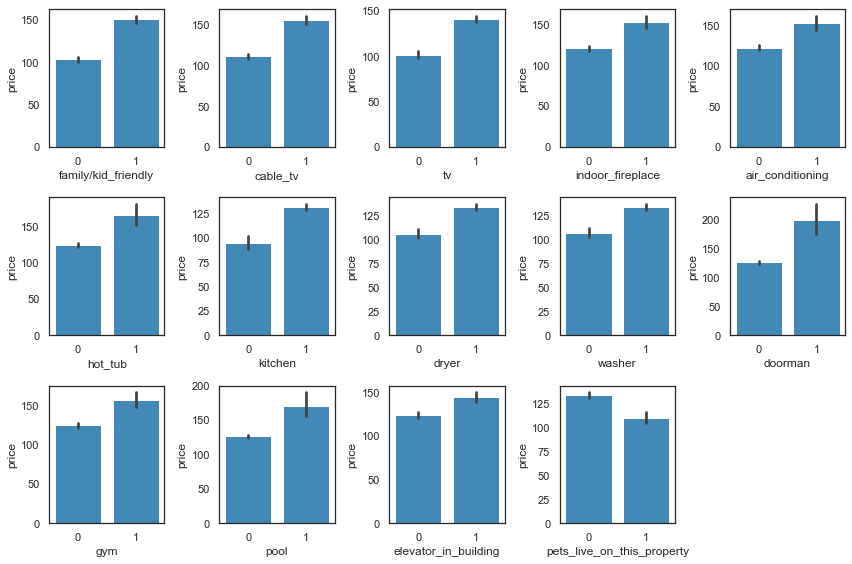

In [686]:
fig = plt.figure(figsize=(12,8))

for i, var in enumerate(amenity_data.columns):
    ax = fig.add_subplot(3, 5, i+1)
    sns.barplot(x=var, y="price", data=listings, color='#2e8dcc')
    
fig.tight_layout()
plt.show() 

**Cleaning fee**

<AxesSubplot:xlabel='cleaning_fee', ylabel='price'>

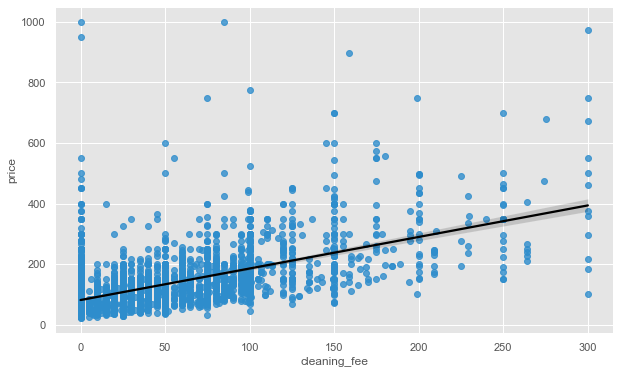

In [179]:
plt.rcParams['figure.figsize'] = [10, 6]
sns.regplot(x="cleaning_fee", y="price", data=listings, scatter_kws={"color": "#2e8dcc"}, line_kws={"color": "black"})

**Review**

<AxesSubplot:xlabel='reviews_per_month', ylabel='price'>

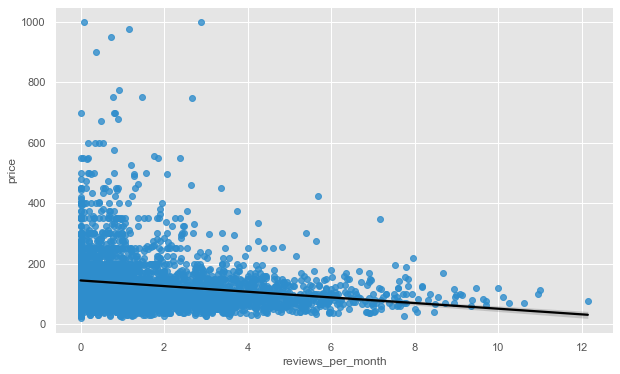

In [180]:
sns.regplot(x="reviews_per_month", y="price", data=listings, scatter_kws={"color": "#2e8dcc"}, line_kws={"color": "black"})

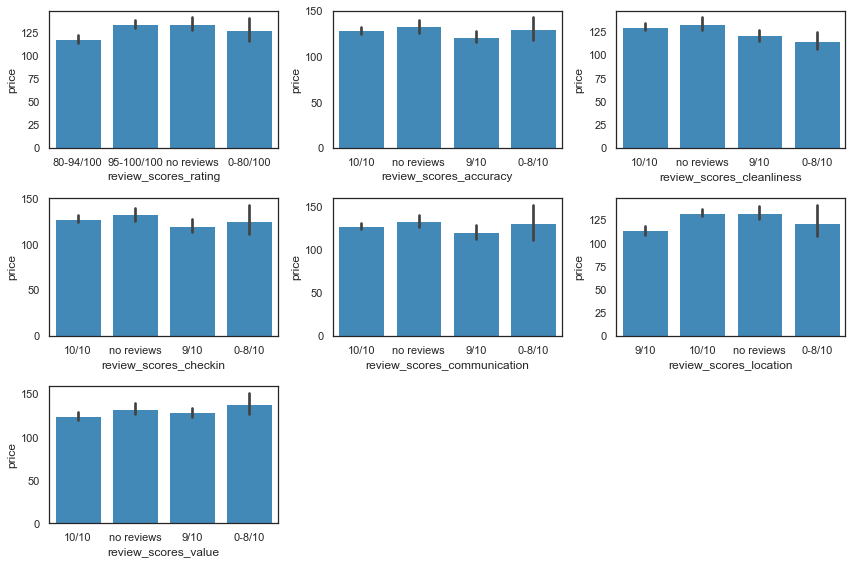

In [673]:
fig = plt.figure(figsize=(12,8))

for i, var in enumerate(variables_to_plot):
    ax = fig.add_subplot(3, 3, i+1)
    sns.barplot(x=var, y="price", data=listings, color='#2e8dcc')
    
fig.tight_layout()
plt.show()  

**Host**

<AxesSubplot:xlabel='host_is_superhost', ylabel='price'>

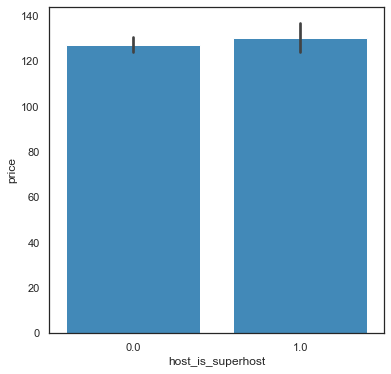

In [681]:
fig = plt.figure(figsize=(6,6))
sns.barplot(x="host_is_superhost", y="price", data=listings, color='#2e8dcc')

<AxesSubplot:xlabel='has_host_about', ylabel='price'>

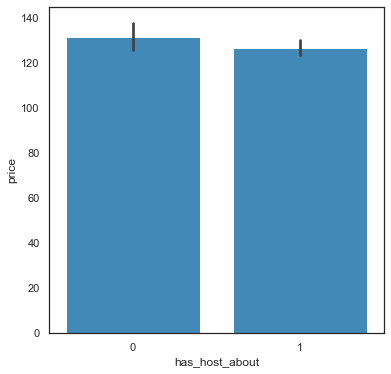

In [682]:
fig = plt.figure(figsize=(6,6))
sns.barplot(x="has_host_about", y="price", data=listings, color='#2e8dcc')

### Price by geolocation

[Text(0.5, 1.0, 'Price by zipcode')]

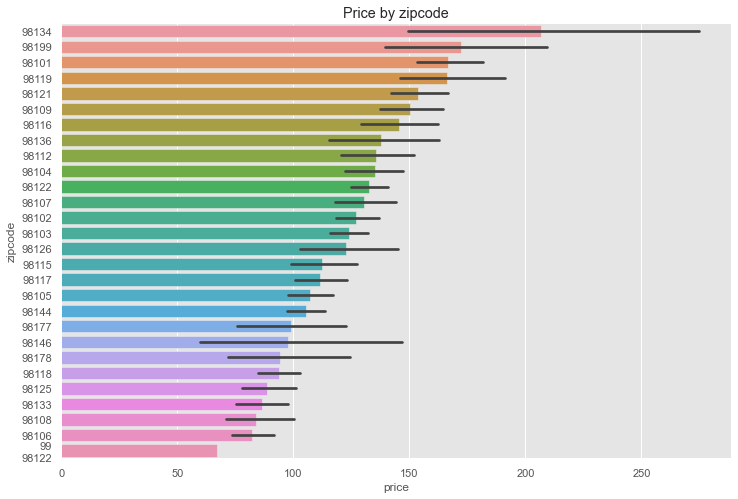

In [573]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.barplot(x="price", y="zipcode", data=listings, order=my_order).set(title='Price by zipcode')

In [104]:
geo_var = ['zipcode', 'longitude', 'latitude', 'price']

listings[geo_var].to_csv('geo_var.csv')

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Visualize geospatial data using kepler, please see the interactive visual <a href="http://localhost:8888/view/Documents/Move/Explorium%20take%20home/ExploriumDataScienceTaskSep22/seattle_geospatial_map.html">here</a>.
    </font>
</div>

# Question 3: Feature Eng.
1. What features can be engineered out of this data? Implement 2-3 examples.


**Amenities**

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        After parsing out the raw amenities column, <b>14 boolean features</b> indicating presence of important amenities and 1  numeric feature <b>number of total amenities</b> are created. Please refer to the previous section.
    </font>
</div>

**Days since first/last review**

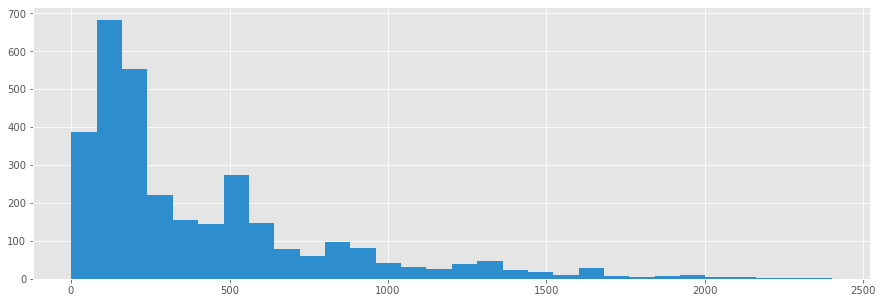

In [172]:
# Calculating the number of days between the first review and the date the data was scraped
listings['days_since_first_review'] = (datetime(2016, 1, 4) - listings['first_review']).astype('timedelta64[D]')

# Distribution of the number of days since first review
listings['days_since_first_review'].hist(figsize=(15,5), bins=30, color = '#2e8dcc');

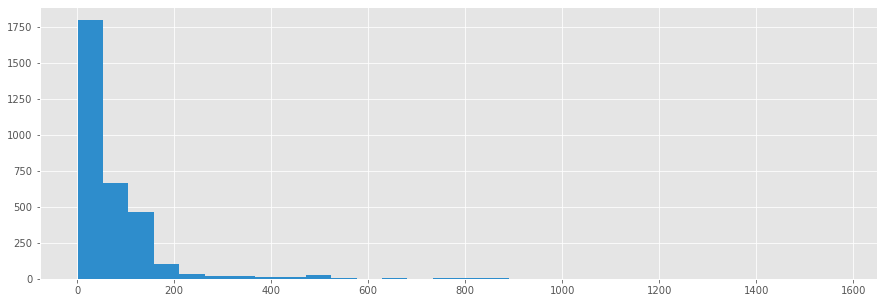

In [173]:
# Calculating the number of days between the most recent review and the date the data was scraped
listings['days_since_last_review'] = (datetime(2016, 1, 4) - listings['last_review']).astype('timedelta64[D]')

# Distribution of the number of days since last review
listings['days_since_last_review'].hist(figsize=(15,5), bins=30, color = '#2e8dcc');

In [170]:
# drop two original date column
listings.drop(columns=[['first_review', 'last_review']], inplace=True)

<AxesSubplot:xlabel='days_since_first_review', ylabel='price'>

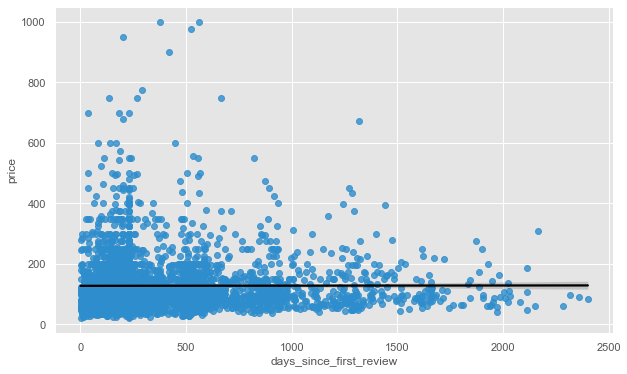

In [181]:
sns.regplot(x="days_since_first_review", y="price", data=listings, scatter_kws={"color": "#2e8dcc"}, line_kws={"color": "black"})

<AxesSubplot:xlabel='days_since_last_review', ylabel='price'>

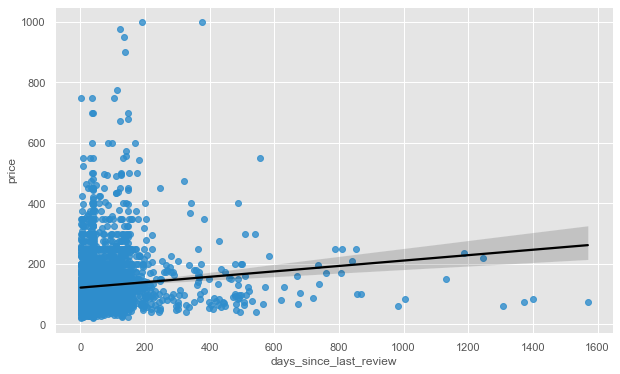

In [182]:
sns.regplot(x="days_since_last_review", y="price", data=listings, scatter_kws={"color": "#2e8dcc"}, line_kws={"color": "black"})

**Host tenure**

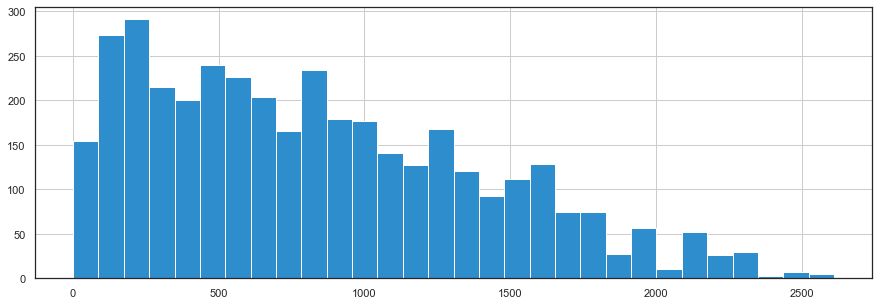

In [314]:
# calculating the number of days since became a host
listings['host_days_tenure'] = (datetime(2016, 1, 4) - listings['host_since']).astype('timedelta64[D]')

# replacing null values with the median
listings['host_days_tenure'].fillna(listings['host_days_tenure'].median(), inplace=True)

# distribution of host_days_tenure
listings['host_days_tenure'].hist(figsize=(15,5), bins=30, color = '#2e8dcc');

In [353]:
# impute missing reviews_per_month
listings['reviews_per_month'].fillna(round(listings['number_of_reviews'] / (listings['host_days_tenure']/30), 2), inplace = True)

In [354]:
# sanity check
listings['reviews_per_month'].isna().sum()

0

**Parse out month, day_of_mth, day_name from date in Calendar data**

In [74]:
# parse month, day_of_mth, day_name from date
calendar['month'] = calendar['date'].dt.month
calendar['day_of_mth'] = calendar['date'].dt.day
calendar['day_name'] = calendar['date'].dt.day_name()

# Question 4: Modeling
1. Which metric would you optimize? Why?
2. Build a basic model to predict the target, present the selected metric on a holdout set

## Put all together (code for data cleaning & feature engineering)

In [110]:
## ---- import data ---- ##

calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')


## ---- helper function ---- ##

# create function to bin numeric features
def bin_column(df, col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].replace('nan', na_label, inplace=True)

In [111]:

## ---- Drop noninformative features ---- ##

# create a list that will save the column name to be dropped.
col_drop = []

col_drop.append('license')
col_drop.extend(['scrape_id', 'last_scraped', 'host_id', 'host_name', 'host_location', 'host_verifications', \
                 'calendar_updated', 'calendar_last_scraped', 'jurisdiction_names']
                )
col_drop.extend(['city', 'state', 'market', 'smart_location', 'country_code', 'country'])
col_drop.extend(['has_availability', 'requires_license'])

# drop all url features
url_var = [c for c in listings.columns if 'url' in c]
col_drop.extend(url_var)



## ---- feature transform ---- ##

# convert price in calendar data to numbers
calendar['price'] = calendar['price'].astype('str').str.replace('[$,]', '', regex=True).astype(float)

# convert string to date
calendar['date'] = pd.to_datetime(calendar['date'], format = '%Y-%m-%d')

# convert string to date
date_var = ['host_since', 'first_review', 'last_review']

for col in date_var:
    listings[col] = pd.to_datetime(listings[col], format = '%Y-%m-%d')

# convert currency to numeric
currency_var = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

for col in currency_var:
    listings[col] = listings[col].astype('str').str.replace('[$,]', '', regex=True).astype(float)

# convert percentage in string to numeric
pct_var = ['host_response_rate', 'host_acceptance_rate']

for col in pct_var:
    listings[col] = listings[col].astype('str').str.replace('%', '', regex=True).astype(float)

# drop host_acceptance_rate due to no signal.
col_drop.append('host_acceptance_rate')

# drop these features as they are redundant to 'neighbourhood_group_cleansed'
col_drop.extend(['host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed'])

# clean zipcode: replace 99\n98122 with 98122
listings['zipcode'].replace('99\n98122', '98122', inplace = True)

# ordinal encode zipcode based on mean price
my_order = listings.groupby('zipcode')['price'].mean().sort_values(ascending=False).index
listings['zipcode_ord'] = listings['zipcode'].map(dict(zip(my_order[::-1], range(0, 27))))

# drop zipcode
col_drop.append('zipcode')

# host_response_time ordinal encoding
listings['host_response_time'] = listings['host_response_time'].map({'within an hour': 0,
                                                                     'within a few hours': 1,
                                                                     'within a day': 2,
                                                                     'a few days or more': 3})
# cancellation_policy ordinal encoding
listings['cancellation_policy'] = listings['cancellation_policy'].map({'flexible': 0,
                                                                     'moderate': 1,
                                                                     'strict': 2})

# combine property_type value levels
property_type = ['House', 'Apartment', 'Townhouse', 'Condominium', 'Loft', 'Boat']
listings['property_type'] = np.where(listings['property_type'].isin(property_type), listings['property_type'], 'Other')

# convert bed_type to boolean
listings['real_bed'] = np.where(listings['bed_type'] == 'Real Bed', 1, 0)

# drop 'bed_type'
col_drop.append('bed_type')

# drop experiences_offered due to invariant value.
col_drop.append('experiences_offered')

# convert accommodates to numeric
listings['accommodates'] = listings['accommodates'].astype('int')

# convert boolean f/t to o/1
bool_var = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', \
            'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']

listings[bool_var] = listings[bool_var].replace({'t': 1, 'f': 0})

# drop host_has_profile_pic due to no signal
listings.drop(columns=['host_has_profile_pic'], inplace=True)

# review rating features
variables_to_plot = list(listings.columns[listings.columns.str.startswith("review_scores") == True])

# binning for all columns scored out of 10
for col in variables_to_plot[1:]:
    bin_column(listings, col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

# binning column scored out of 100
bin_column(listings, 'review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-80/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

# binning for host_response_rate
bin_column(listings, 'host_response_rate',
           bins=[0, 80, 95, 100],
           labels=['0-80/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

# drop two redundant listings_count features
col_drop.extend(['host_total_listings_count', 'calculated_host_listings_count'])

# drop latitude and longitude
col_drop.extend(['latitude', 'longitude'])

# calculate price standard deviation by listing
df_price_std = calendar.groupby('listing_id')['price'].std().reset_index()
df_price_std.columns = ['listing_id', 'price_std']

# create fix_price flag
df_price_std['fix_price'] = np.where(df_price_std['price_std']==0, 1, 0)


## ---- parse out amenities ---- ##

# clean and parse out each item in the list
listings["amenities"] = listings["amenities"].str.lower().replace('[{"}]', '', regex=True)  \
                                             .str.replace(' ','_')   \
                                             .str.split(',')

# use MultiLabelBinarizer to obtain amenities matrix
mlb = MultiLabelBinarizer()
amenities_mat = pd.DataFrame(mlb.fit_transform(listings["amenities"]),
                             columns=mlb.classes_)

# add number of amenities by listing to the main df
listings = pd.concat([listings, pd.DataFrame(amenities_mat.sum(axis = 1), columns = ['num_amenities'])], axis=1)

# concatenate price to amenities_mat and calculate correlation
amenities_mat = pd.concat([amenities_mat, listings['price']], axis=1)

# calculate correlation
corr = amenities_mat.corr()[['price']].sort_values(by='price', ascending=False)
corr.columns = ['Correlation_with_price']

# amenity frequency sort by correlation with price
amenity_smry = pd.merge(pd.DataFrame(amenities_mat.sum(), columns = ['Frequency']), corr[1:], left_index=True, right_index=True) \
  .sort_values(by='Correlation_with_price', ascending=False)

# select top amenities and most negative amenity
amenity_data = amenities_mat[amenity_smry.query('Correlation_with_price > 0.09 or Correlation_with_price < -0.11').index.to_list()]

# append amenity data to main listings data
listings = pd.concat([listings, amenity_data], axis=1)

# drop amenities
col_drop.append('amenities')


## ---- numeric features missing imputation---- ##

# check feature missing rate
listings_missing = listings.isnull().sum() / len(listings)

df_list_missing = pd.DataFrame(listings_missing.sort_values(ascending=False), columns = ['missing_rate'])

# check missing pct for all numeric var
df_high_miss_num = df_list_missing[df_list_missing.index.isin(listings.select_dtypes(include=np.number).columns.tolist())]

# create features to flag out missing values for high missing features
missing_num_var = df_high_miss_num.query("missing_rate > 0.1 and missing_rate < 1").index.to_list()

df_miss_num_flags = pd.DataFrame(listings[missing_num_var].isna().astype(int))
df_miss_num_flags.columns = ['miss_' + col for col in missing_num_var]

# append df_miss_num_flags data to main listings data
listings = pd.concat([listings, df_miss_num_flags], axis=1)

# drop square_feet
col_drop.append('square_feet')

# impute monthly and weekly price with median
for col in ['monthly_price', 'weekly_price']:
    listings[col].fillna(listings[col].median(), inplace=True)

# impute security deposit and cleaning fee with 0
for col in ['security_deposit', 'cleaning_fee']:
    listings[col].fillna(0, inplace=True)

# impute host_response_time missing with median
listings['host_response_time'].fillna(listings['host_response_time'].median(), inplace=True)



## ---- text features ---- ##

text_var = ['name', 'description', 'street', 'summary', 'space', 'neighborhood_overview', 'notes', 'transit', 'host_about']

# drop street 
#col_drop.append('street')

# create boolean features has_ + info
has_info = listings[text_var[3:]].notnull().astype(int)
df_has_info = pd.DataFrame(has_info)
df_has_info.columns = ['has_' + col for col in text_var[3:]]

# append has_info data to main listings data
listings = pd.concat([listings, df_has_info], axis=1)

# drop original columns and append new features to listings
#col_drop.extend(text_var[3:])
col_drop.extend(text_var)


## ---- feature engineering ---- ##

# Calculating the number of days between the first review and the date the data was scraped
listings['days_since_first_review'] = (datetime(2016, 1, 4) - listings['first_review']).astype('timedelta64[D]')

# replacing null values with the median
listings['days_since_first_review'].fillna(listings['days_since_first_review'].median(), inplace=True)

# Calculating the number of days between the most recent review and the date the data was scraped
listings['days_since_last_review'] = (datetime(2016, 1, 4) - listings['last_review']).astype('timedelta64[D]')

# replacing null values with the median
listings['days_since_last_review'].fillna(listings['days_since_last_review'].median(), inplace=True)

# calculating the number of days since becoming a host
listings['host_days_tenure'] = (datetime(2016, 1, 4) - listings['host_since']).astype('timedelta64[D]')

# replacing null values with the median
listings['host_days_tenure'].fillna(listings['host_days_tenure'].median(), inplace=True)

# drop three original date columns
col_drop.extend(['first_review', 'last_review', 'host_since'])

# impute missing reviews_per_month
listings['reviews_per_month'].fillna(round(listings['number_of_reviews'] / (listings['host_days_tenure']/30), 2), inplace = True)

# parse month, day_of_mth, day_name from date
calendar['month'] = calendar['date'].dt.month
calendar['day_of_mth'] = calendar['date'].dt.day
calendar['day_name'] = calendar['date'].dt.day_name()


## ---- drop features in col_drop ---- ##

listings.drop(columns='id', inplace=True)
listings.drop(columns=col_drop, inplace=True)



## ---- rename columns for shorter dummy feature names ---- ##

listings.rename({"host_response_rate": "host_resp_rate", 
                 "neighbourhood_group_cleansed": "neighbour", 
                 "review_scores_rating": "rating_scr", 
                 "review_scores_accuracy": "accuracy_scr",
                 "review_scores_cleanliness": "clean_scr",
                 "review_scores_checkin": "checkin_scr",
                 "review_scores_communication": "commu_scr",
                 "review_scores_value": "value_scr"},
                 axis = "columns", inplace = True)



In [9]:
# sanity check
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 73 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3818 non-null   float64
 1   host_resp_rate                    3818 non-null   object 
 2   host_is_superhost                 3816 non-null   float64
 3   host_listings_count               3816 non-null   float64
 4   host_identity_verified            3816 non-null   float64
 5   neighbour                         3818 non-null   object 
 6   is_location_exact                 3818 non-null   int64  
 7   property_type                     3818 non-null   object 
 8   room_type                         3818 non-null   object 
 9   accommodates                      3818 non-null   int64  
 10  bathrooms                         3802 non-null   float64
 11  bedrooms                          3812 non-null   float64
 12  beds  

## Model 1: Predict listing price on scrape date (2016-01-04)

### Prepare data for modeling

In [27]:
# one-hot-encode categorical variables
model_df = pd.get_dummies(listings)

model_df.head()

,host_response_time,host_is_superhost,host_listings_count,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,zipcode_ord,real_bed,num_amenities,family/kid_friendly,cable_tv,tv,indoor_fireplace,air_conditioning,hot_tub,kitchen,dryer,washer,doorman,gym,pool,elevator_in_building,pets_live_on_this_property,miss_square_feet,miss_monthly_price,miss_security_deposit,miss_weekly_price,miss_cleaning_fee,miss_host_acceptance_rate,miss_reviews_per_month,miss_host_response_time,has_summary,has_space,has_neighborhood_overview,has_notes,has_transit,has_host_about,days_since_first_review,days_since_last_review,host_days_tenure,host_resp_rate_0-80/100,host_resp_rate_80-94/100,host_resp_rate_95-100/100,host_resp_rate_no reviews,neighbour_Ballard,neighbour_Beacon Hill,neighbour_Capitol Hill,neighbour_Cascade,neighbour_Central Area,neighbour_Delridge,neighbour_Downtown,neighbour_Interbay,neighbour_Lake City,neighbour_Magnolia,neighbour_Northgate,neighbour_Other neighborhoods,neighbour_Queen Anne,neighbour_Rainier Valley,neighbour_Seward Park,neighbour_University District,neighbour_West Seattle,property_type_Apartment,property_type_Boat,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,rating_scr_0-80/100,rating_scr_80-94/100,rating_scr_95-100/100,rating_scr_no reviews,accuracy_scr_0-8/10,accuracy_scr_10/10,accuracy_scr_9/10,accuracy_scr_no reviews,clean_scr_0-8/10,clean_scr_10/10,clean_scr_9/10,clean_scr_no reviews,checkin_scr_0-8/10,checkin_scr_10/10,checkin_scr_9/10,checkin_scr_no reviews,commu_scr_0-8/10,commu_scr_10/10,commu_scr_9/10,commu_scr_no reviews,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_no reviews,value_scr_0-8/10,value_scr_10/10,value_scr_9/10,value_scr_no reviews
0,1.0,0.0,3.0,1.0,1,4,1.0,1.0,1.0,85.0,650.0,2200.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,0,1,0,0,4.07,23.0,1,10,1,1,1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,1525.0,2.0,1607.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0.0,1.0,6.0,1.0,1,4,1.0,1.0,1.0,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,0,2,1,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,868.0,6.0,1047.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,1.0,0.0,2.0,1.0,1,11,4.5,5.0,7.0,975.0,650.0,2200.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,0,2,0,0,1.15,23.0,1,21,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,0,1,0,0,0,0,1,1,1,1,1,1,523.0,123.0,571.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,0.0,0.0,1.0,1.0,1,3,1.0,0.0,2.0,100.0,650.0,2300.0,0.0,0.0,1,0.0,1,1125,0,0,0,143,0,0,0,0,0,0.00,23.0,1,14,1,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,0,0,0,232.0,40.0,789.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,0.0,0.0,2.0,1.0,1,6,2.0,3.0,3.0,450.0,650.0,2200.0,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,0,2,0,0,0.89,23.0,1,13,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1273.0,72.0,1497.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [28]:
model_df.shape

(3818, 121)

#### Correlation Matrix

In [6]:
def correlation_heatmap(df, figsize=(32,28)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

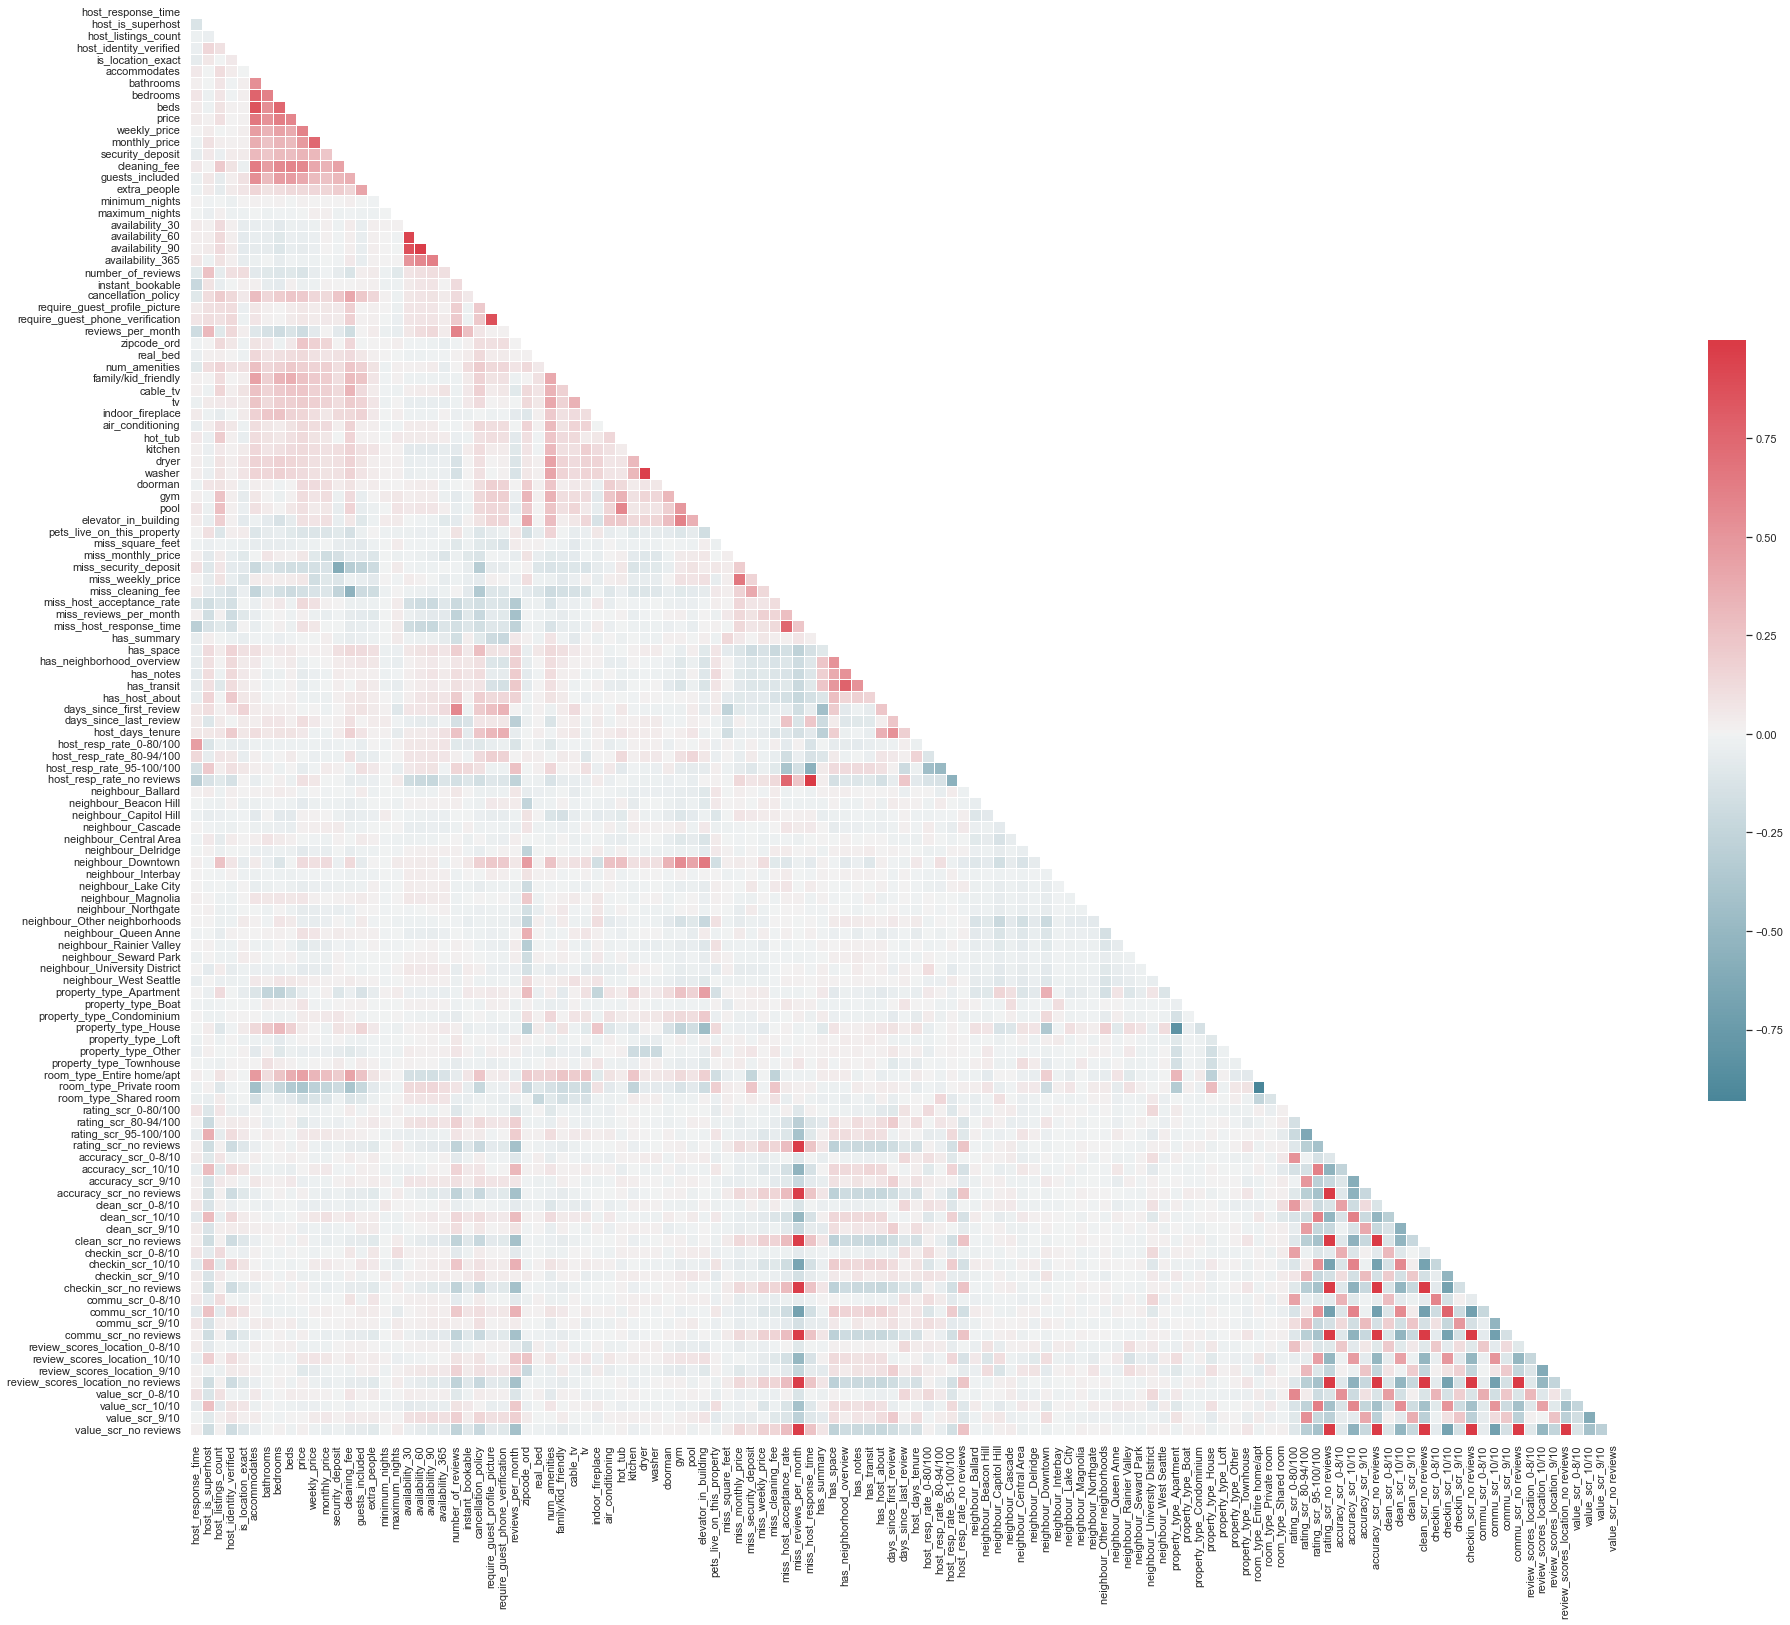

In [23]:
correlation_heatmap(model_df)

In [30]:
# redundant features that might cause multi-collinearity
corr_rank = model_df.corr().unstack().sort_values(ascending=False)
print(corr_rank[(corr_rank<1) & (corr_rank >0.6)])

review_scores_location_no reviews  value_scr_no reviews                 0.999080
value_scr_no reviews               review_scores_location_no reviews    0.999080
accuracy_scr_no reviews            checkin_scr_no reviews               0.998164
checkin_scr_no reviews             accuracy_scr_no reviews              0.998164
commu_scr_no reviews               clean_scr_no reviews                 0.998152
                                                                          ...   
price                              weekly_price                         0.605670
elevator_in_building               gym                                  0.603875
gym                                elevator_in_building                 0.603875
number_of_reviews                  reviews_per_month                    0.601509
reviews_per_month                  number_of_reviews                    0.601509
Length: 110, dtype: float64


In [29]:
# features to drop
to_drop = ['beds',
           'bathrooms',
           'guests_included',
           'weekly_price',
           'monthly_price',
           'availability_60',
           'require_guest_profile_picture',
           'dryer']
to_drop.extend(list(model_df.columns[model_df.columns.str.endswith('no reviews')]))
to_drop

['beds',
 'bathrooms',
 'guests_included',
 'weekly_price',
 'monthly_price',
 'availability_60',
 'require_guest_profile_picture',
 'dryer',
 'host_resp_rate_no reviews',
 'rating_scr_no reviews',
 'accuracy_scr_no reviews',
 'clean_scr_no reviews',
 'checkin_scr_no reviews',
 'commu_scr_no reviews',
 'review_scores_location_no reviews',
 'value_scr_no reviews']

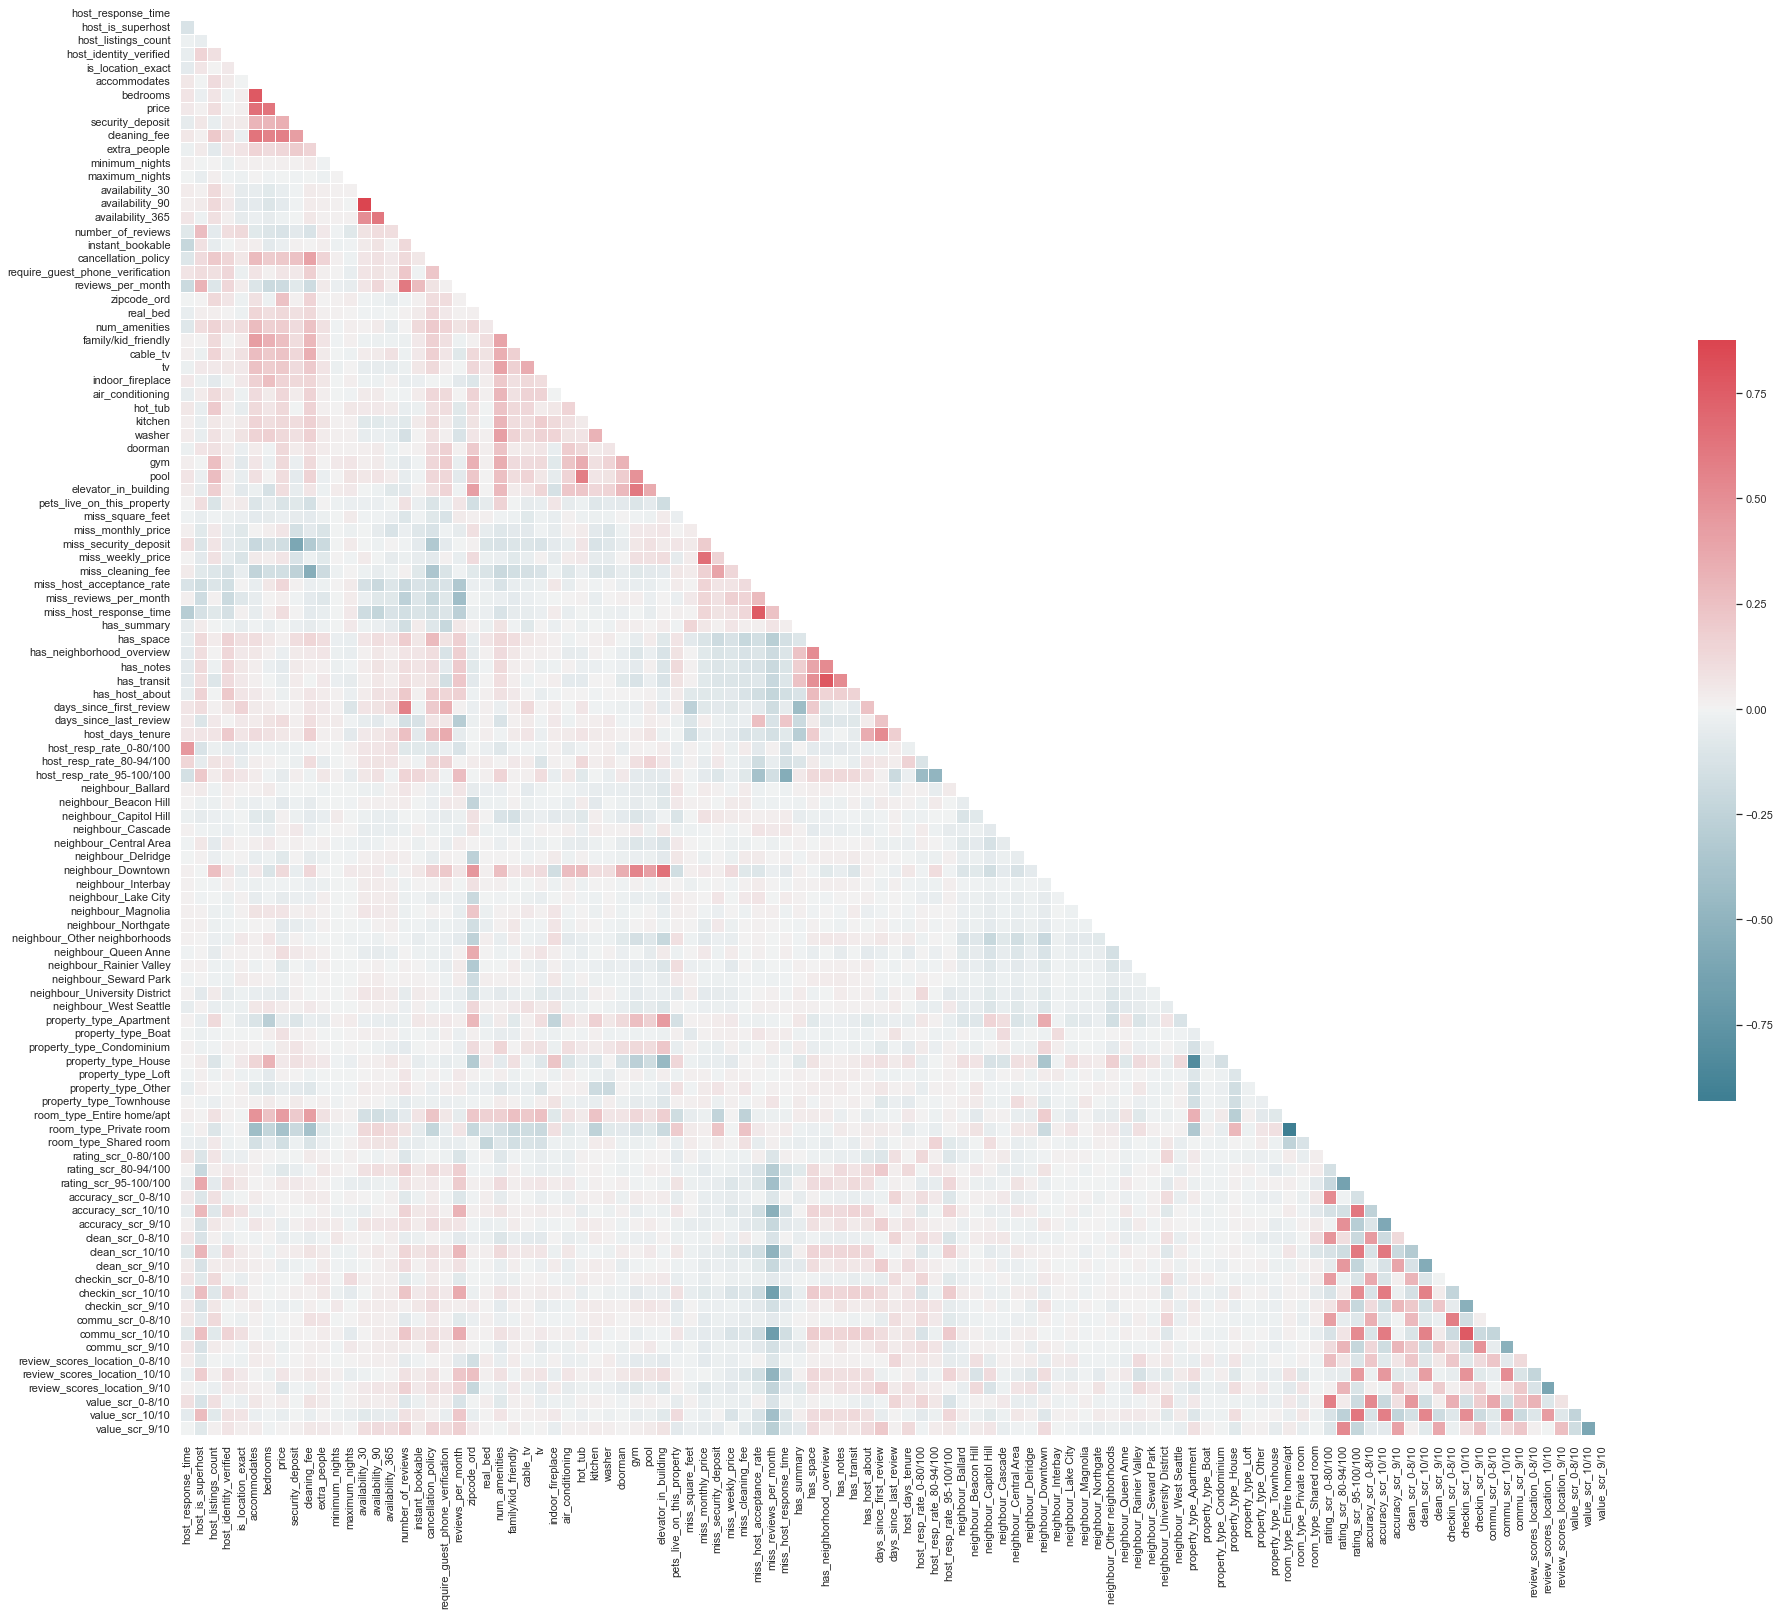

In [30]:
# drop redundant features and examine correlation
model_df.drop(to_drop, axis=1, inplace=True)
correlation_heatmap(model_df)

In [31]:
model_df.shape

(3818, 105)

In [32]:
# separate X and y
X = model_df.drop('price', axis=1)
y = model_df.price

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Build XGBoost regressor

<div class="alert alert-block alert-info">
    <font color=black><b>Optimization metric selection:</b> <p></p>
        To optimize performance for a regression model, we often look at <b>root mean squared error (RMSE)</b>  or <b>mean absolute error (MAE)</b>. These measurements are both commonly used for comparing regression model performance, but they have slightly different intuition and mathematical meaning.
        <p></p>
<li>MAE: the mean absolute error tells us on average how far our predictions are from the true value. In this case, all errors receive the same weight.</li>
<li>RMSE: we calculate RMSE by taking the square root of the sum of all of the squared errors. When we square, <b>the larger errors have a greater impact on the overall error</b> while smaller errors do not have as much weight on the overall error. This means RMSE tends to be affected by outliers.</li>
        <p></p>
        Because there are  lots of outliers in listings price, so for this model, <b>we will choose MSE as the optimization metric</b>, as it's more robust to outliers.
    </font>
</div>

In [452]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================

# instantiate regressor
regressor = xgb.XGBRegressor(eval_metric = 'mae')


# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [300, 400, 500],
              "learning_rate": [0.01, 0.015],
              "gamma": [0.01, 0.1, 0.05],
              "colsample_bytree": [0.3, 0.5, 0.8]}

# grid search to try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'gamma': 0.1, 'learning_rate': 0.015, 'max_depth': 5, 'n_estimators': 700}


In [453]:
regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                             n_estimators  = search.best_params_["n_estimators"],
                             max_depth     = search.best_params_["max_depth"],
                             gamma   = search.best_params_["gamma"],
                             colsample_bytree  = search.best_params_["colsample_bytree"],
                             eval_metric='mae')

regressor.fit(X_train, y_train)

# score the prices for the train data
train_preds = regressor.predict(X_train)

# predict the prices for the test data
test_preds = regressor.predict(X_test)

# print evaluation metric
print("\nTraining MSE: %.4f" % mean_absolute_error(y_train, train_preds))
print("Test MSE: %.4f" % mean_absolute_error(y_test, test_preds))
print("\nTraining r2: %.4f" % r2_score(y_train, train_preds))
print("Test r2: %.4f" % r2_score(y_test, test_preds))

In [190]:
regressor = xgb.XGBRegressor(learning_rate = 0.04,
                             n_estimators  = 50,
                             max_depth     = 3,
                             gamma   = 0.1,
                             subsample = 0.7,
                             colsample_bytree  = 0.8,
                             eval_metric = 'mae')

regressor.fit(X_train, y_train)

# score the prices for the train data
train_preds = regressor.predict(X_train)

# predict the prices for the test data
test_preds = regressor.predict(X_test)

# print evaluation metric
print("\nTraining MSE: %.4f" % mean_absolute_error(y_train, train_preds))
print("Test MSE: %.4f" % mean_absolute_error(y_test, test_preds))
print("\nTraining r2: %.4f" % r2_score(y_train, train_preds))
print("Test r2: %.4f" % r2_score(y_test, test_preds))


Training MSE: 32.8122
Test MSE: 32.4229

Training r2: 0.5837
Test r2: 0.5415


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        The MSE and R2 looks good for both train and test data, but there is significant overfitting based on the difference between metric on train and test.
    </font>
</div>

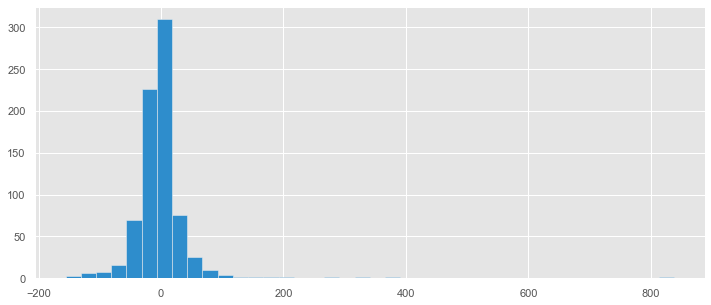

In [492]:
# check residual distribution
(y_test - test_preds).hist(figsize=(12,5), bins=40, color = '#2e8dcc');

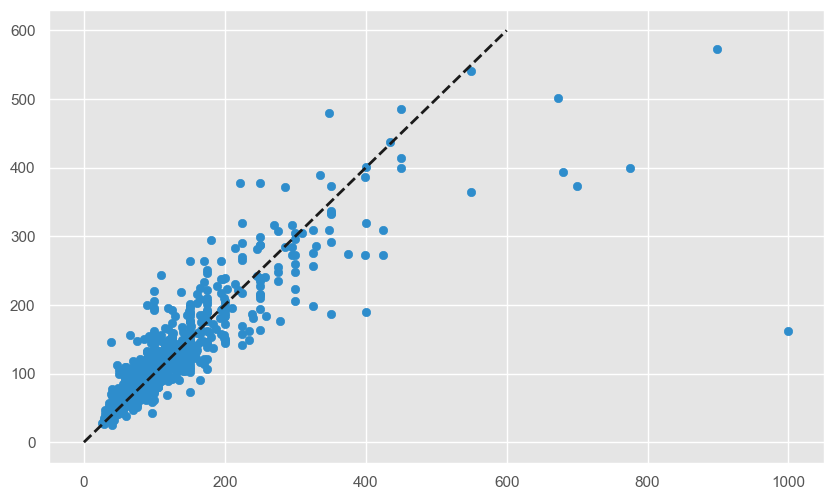

In [503]:
# plot y vs y_hat 
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(y_test, test_preds, color = '#2e8dcc')
plt.plot([0,600], [0,600], linestyle='--', color='k', lw=2)
plt.show()

In [504]:
# error analysis
model_df.query("price >= 1000")

,host_response_time,host_is_superhost,host_listings_count,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,zipcode_ord,real_bed,num_amenities,family/kid_friendly,cable_tv,tv,indoor_fireplace,air_conditioning,hot_tub,kitchen,dryer,washer,doorman,gym,pool,elevator_in_building,pets_live_on_this_property,miss_square_feet,miss_monthly_price,miss_security_deposit,miss_weekly_price,miss_cleaning_fee,miss_host_acceptance_rate,miss_reviews_per_month,miss_host_response_time,has_summary,has_space,has_neighborhood_overview,has_notes,has_transit,has_host_about,days_since_first_review,days_since_last_review,host_days_tenure,host_resp_rate_0-80/100,host_resp_rate_80-94/100,host_resp_rate_95-100/100,host_resp_rate_no reviews,neighbour_Ballard,neighbour_Beacon Hill,neighbour_Capitol Hill,neighbour_Cascade,neighbour_Central Area,neighbour_Delridge,neighbour_Downtown,neighbour_Interbay,neighbour_Lake City,neighbour_Magnolia,neighbour_Northgate,neighbour_Other neighborhoods,neighbour_Queen Anne,neighbour_Rainier Valley,neighbour_Seward Park,neighbour_University District,neighbour_West Seattle,property_type_Apartment,property_type_Boat,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,rating_scr_0-80/100,rating_scr_80-94/100,rating_scr_95-100/100,rating_scr_no reviews,accuracy_scr_0-8/10,accuracy_scr_10/10,accuracy_scr_9/10,accuracy_scr_no reviews,clean_scr_0-8/10,clean_scr_10/10,clean_scr_9/10,clean_scr_no reviews,checkin_scr_0-8/10,checkin_scr_10/10,checkin_scr_9/10,checkin_scr_no reviews,commu_scr_0-8/10,commu_scr_10/10,commu_scr_9/10,commu_scr_no reviews,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_no reviews,value_scr_0-8/10,value_scr_10/10,value_scr_9/10,value_scr_no reviews
3122,0.0,0.0,1.0,1.0,1,4,1.0,2.0,2.0,1000.0,650.0,2200.0,0.0,0.0,1,0.0,1,1125,23,53,83,358,1,0,0,0,0,0.08,11.0,1,13,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,378.0,378.0,1683.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0


In [510]:
np.where(y_test==1000)[0]

array([337])

In [36]:
# print evaluation metric
test_preds = pd.Series(test_preds)
y_test_2 = y_test.drop(y_test.index[337])
test_preds_2 = test_preds.drop(test_preds.index[337])

print("\nTraining MSE: %.4f" % mean_absolute_error(y_train, train_preds))
print("Validation MSE: %.4f" % mean_absolute_error(y_test_2, test_preds_2))
print("\nTraining r2: %.4f" % r2_score(y_train, train_preds))
print("Validation r2: %.4f" % r2_score(y_test_2, test_preds_2))


Training MSE: 10.8327
Validation MSE: 28.7120

Training r2: 0.9709
Validation r2: 0.7302


### Model interpretation

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Feature importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.
    </font>
</div>

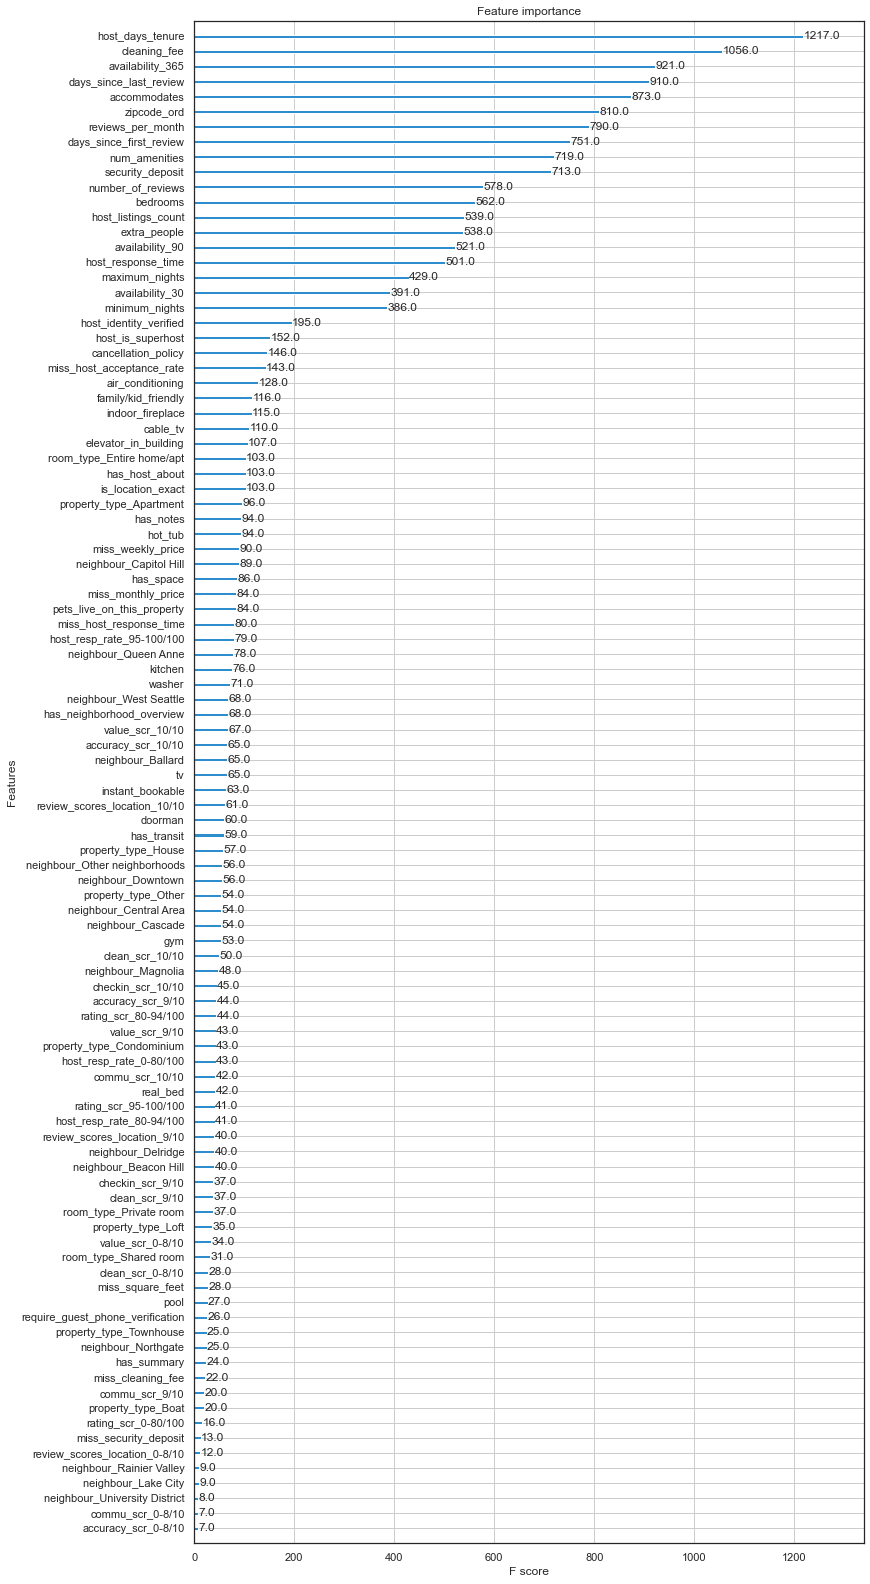

In [35]:
# Feature Importance
fig, ax = plt.subplots(figsize=(12,28))
plot_importance(regressor, max_num_features=100, ax=ax, color = '#2e8dcc')
plt.show()

In [61]:
# permutation importance
perm_imp = PermutationImportance(regressor, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm_imp, feature_names = X_test.columns.tolist())

Weight,Feature
0.2500 ± 0.0400,bedrooms
0.1257 ± 0.0242,accommodates
0.0410 ± 0.0077,zipcode_ord
0.0335 ± 0.0054,room_type_Entire home/apt
0.0321 ± 0.0085,days_since_last_review
0.0300 ± 0.0139,cleaning_fee
0.0121 ± 0.0035,security_deposit
0.0106 ± 0.0079,number_of_reviews
0.0099 ± 0.0078,reviews_per_month
0.0081 ± 0.0024,miss_host_acceptance_rate


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is rectangular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled
    </font>
</div>

<div class="alert alert-block alert-warning">
    <font color=black><b>Potential next steps to mitigate overfitting: </b> 
        <li>Select top N features based on feature importance and build model.</li>
        <li>Further remove correlated features.</li>
        <li>Remove outliers in listings price before model training.</li>
        <li>Introduce regularization when building XGBoost models to mitigate overfitting.</li>
        <li>Gather more data samples to make model more generalizable.</li>
    </font>
</div>

### XGBoost regressor on log(price)

In [727]:
# transform y to y_log
y_log = np.log(model_df.price)

# split into train and test sets
X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.2, random_state=123)

In [731]:
regressor_log = xgb.XGBRegressor(learning_rate = 0.04,
                             n_estimators  = 500,
                             max_depth     = 5,
                             gamma   = 0.1,
                             subsample = 0.7,
                             colsample_bytree  = 0.8,
                             eval_metric = 'mae')

regressor_log.fit(X_train, y_log_train)

# score the prices for the train data
log_train_preds = regressor_log.predict(X_train)

# predict the prices for the test data
log_test_preds = regressor_log.predict(X_test)

# print evaluation metric after inverse transform log_price to original price
print("\nTraining MSE: %.4f" % mean_absolute_error(np.exp(y_log_train), np.exp(log_train_preds)))
print("Validation MSE: %.4f" % mean_absolute_error(np.exp(y_log_test), np.exp(log_test_preds)))
print("\nTraining r2: %.4f" % r2_score(np.exp(y_log_train), np.exp(log_train_preds)))
print("Validation r2: %.4f" % r2_score(np.exp(y_log_test), np.exp(log_test_preds)))


Training MSE: 13.7114
Validation MSE: 24.1500

Training r2: 0.9264
Validation r2: 0.7190


In [732]:
# print evaluation metric for log_price
print("\nTraining MSE: %.4f" % mean_absolute_error(y_log_train, log_train_preds))
print("Validation MSE: %.4f" % mean_absolute_error(y_log_test, log_test_preds))
print("\nTraining r2: %.4f" % r2_score(y_log_train, log_train_preds))
print("Validation r2: %.4f" % r2_score(y_log_test, log_test_preds))


Training MSE: 0.1038
Validation MSE: 0.1743

Training r2: 0.9394
Validation r2: 0.8256


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        Use price log transformation as target to build model only produces marginal performance lift.
    </font>
</div>

## Model 2: Identify fix price listings

### Prepare data for modeling

In [112]:
# merge it to main data
listings_2 = pd.merge(listings, df_price_std[['listing_id', 'fix_price']], how='left', left_on='id', right_on='listing_id')

In [98]:
# sanity check
listings_2.head(1)

,id,host_response_time,host_resp_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbour,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,rating_scr,accuracy_scr,clean_scr,checkin_scr,commu_scr,review_scores_location,value_scr,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,zipcode_ord,real_bed,num_amenities,family/kid_friendly,cable_tv,tv,indoor_fireplace,air_conditioning,hot_tub,kitchen,dryer,washer,doorman,gym,pool,elevator_in_building,pets_live_on_this_property,miss_square_feet,miss_monthly_price,miss_security_deposit,miss_weekly_price,miss_cleaning_fee,miss_host_acceptance_rate,miss_reviews_per_month,miss_host_response_time,has_summary,has_space,has_neighborhood_overview,has_notes,has_transit,has_host_about,days_since_first_review,days_since_last_review,host_days_tenure,listing_id,fix_price
0,241032,1.0,95-100/100,0.0,3.0,1.0,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,85.0,650.0,2200.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,80-94/100,10/10,10/10,10/10,10/10,9/10,10/10,0,1,0,0,4.07,23.0,1,10,1,1,1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,1525.0,2.0,1607.0,241032,1


In [48]:
listings_2.drop(['id', 'listing_id', 'price'], axis=1, inplace=True)

In [49]:
# one-hot-encode categorical variables
model_df2 = pd.get_dummies(listings_2)

model_df2.head()

,host_response_time,host_is_superhost,host_listings_count,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,zipcode_ord,real_bed,num_amenities,family/kid_friendly,cable_tv,tv,indoor_fireplace,air_conditioning,hot_tub,kitchen,dryer,washer,doorman,gym,pool,elevator_in_building,pets_live_on_this_property,miss_square_feet,miss_monthly_price,miss_security_deposit,miss_weekly_price,miss_cleaning_fee,miss_host_acceptance_rate,miss_reviews_per_month,miss_host_response_time,has_summary,has_space,has_neighborhood_overview,has_notes,has_transit,has_host_about,days_since_first_review,days_since_last_review,host_days_tenure,fix_price,host_resp_rate_0-80/100,host_resp_rate_80-94/100,host_resp_rate_95-100/100,host_resp_rate_no reviews,neighbour_Ballard,neighbour_Beacon Hill,neighbour_Capitol Hill,neighbour_Cascade,neighbour_Central Area,neighbour_Delridge,neighbour_Downtown,neighbour_Interbay,neighbour_Lake City,neighbour_Magnolia,neighbour_Northgate,neighbour_Other neighborhoods,neighbour_Queen Anne,neighbour_Rainier Valley,neighbour_Seward Park,neighbour_University District,neighbour_West Seattle,property_type_Apartment,property_type_Boat,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,rating_scr_0-80/100,rating_scr_80-94/100,rating_scr_95-100/100,rating_scr_no reviews,accuracy_scr_0-8/10,accuracy_scr_10/10,accuracy_scr_9/10,accuracy_scr_no reviews,clean_scr_0-8/10,clean_scr_10/10,clean_scr_9/10,clean_scr_no reviews,checkin_scr_0-8/10,checkin_scr_10/10,checkin_scr_9/10,checkin_scr_no reviews,commu_scr_0-8/10,commu_scr_10/10,commu_scr_9/10,commu_scr_no reviews,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_no reviews,value_scr_0-8/10,value_scr_10/10,value_scr_9/10,value_scr_no reviews
0,1.0,0.0,3.0,1.0,1,4,1.0,1.0,1.0,650.0,2200.0,0.0,0.0,2,5.0,1,365,14,41,71,346,207,0,1,0,0,4.07,23.0,1,10,1,1,1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,1525.0,2.0,1607.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,0.0,1.0,6.0,1.0,1,4,1.0,1.0,1.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,0,2,1,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,868.0,6.0,1047.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,1.0,0.0,2.0,1.0,1,11,4.5,5.0,7.0,650.0,2200.0,1000.0,300.0,10,25.0,4,30,1,6,17,220,20,0,2,0,0,1.15,23.0,1,21,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,0,1,0,0,0,0,1,1,1,1,1,1,523.0,123.0,571.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,0.0,0.0,1.0,1.0,1,3,1.0,0.0,2.0,650.0,2300.0,0.0,0.0,1,0.0,1,1125,0,0,0,143,0,0,0,0,0,0.00,23.0,1,14,1,0,0,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,0,0,0,232.0,40.0,789.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,0.0,0.0,2.0,1.0,1,6,2.0,3.0,3.0,650.0,2200.0,700.0,125.0,6,15.0,1,1125,30,60,90,365,38,0,2,0,0,0.89,23.0,1,13,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1273.0,72.0,1497.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [50]:
# separate X and y (target "fix_price")
X_2 = model_df2.drop('fix_price', axis=1)
y_2 = model_df2['fix_price']

# split into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, stratify=y_2, random_state=123)

### Build a XGBoost Classifier

In [724]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================

# instantiate regressor
classifier = xgb.XGBClassifier(eval_metric = 'logloss')


# set up our search grid
param_grid2 = {"max_depth":    [4, 5],
              "n_estimators": [500, 700],
              "learning_rate": [0.01, 0.02, 0.04],
              "gamma": [0.01, 0.1, 0.5],
              "colsample_bytree": [0.3, 0.5, 0.8]}

# grid search to try out every combination of the above values
search_2 = GridSearchCV(classifier, param_grid2, cv=5, n_jobs=-1, verbose=2).fit(X_train_2, y_train_2)

print("The best hyperparameters are ",search_2.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
The best hyperparameters are  {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 700}
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=700; total time=   3.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, n_estimators=500; total time=   3.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=4, n_estimators=500; total time=   2.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=4, n_estimators=700; total time=   3.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, n_estimators=500; total time=   3.3s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=4, n_estimators=500; total time=   2.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, n_estimators=500; total time=   3.2s
[CV] END colsamp

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=500; total time=   2.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, n_estimators=700; total time=   3.8s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=4, n_estimators=500; total time=   2.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=4, n_estimators=500; total time=   2.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, n_estimators=500; total time=   3.3s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=4, n_estimators=500; total time=   2.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=4, n_estimators=500; total time=   2.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, n_estimators=500; total time=   3.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, n_estimators=700; to

In [51]:
classifier = xgb.XGBClassifier(learning_rate = search_2.best_params_["learning_rate"],
                               n_estimators  = search_2.best_params_["n_estimators"],
                               max_depth     = search_2.best_params_["max_depth"],
                               gamma   = search_2.best_params_["gamma"],
                               colsample_bytree  = search_2.best_params_["colsample_bytree"],
                               eval_metric = 'logloss')

classifier.fit(X_train_2, y_train_2)

# score the prices for the train data
train_preds_2 = classifier.predict(X_train_2)

# predict the prices for the test data
test_preds_2 = classifier.predict(X_test_2)

# print evaluation metric
print("\nTraining accuracy: %.4f" % accuracy_score(y_train_2, train_preds_2))
print("Test accuracy: %.4f" % accuracy_score(y_test_2, test_preds_2))
print("\nTraining AUC: %.4f" % roc_auc_score(y_train_2, train_preds_2))
print("Test AUC: %.4f" % roc_auc_score(y_test_2, test_preds_2))


Training accuracy: 0.8690
Test accuracy: 0.7723

Training AUC: 0.8620
Test AUC: 0.7613


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        AUC for both train and test looks pretty good, which means our model is very predictive in terms of identifying listings with fix price.
    </font>
</div>

### Model Interpretation

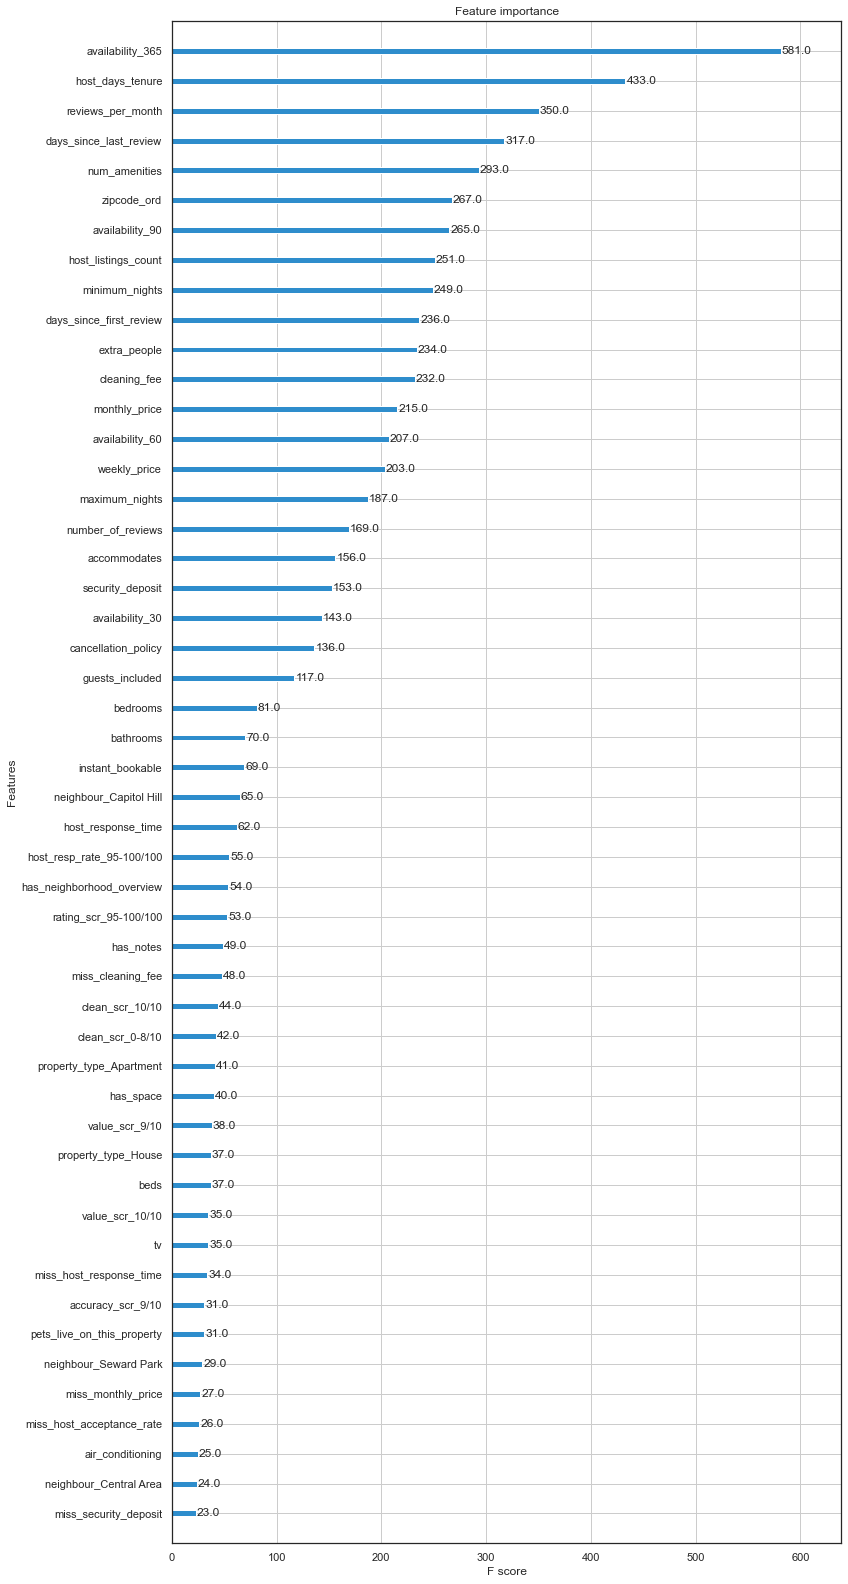

In [52]:
# Feature Importance
fig, ax = plt.subplots(figsize=(12,28))
plot_importance(classifier, max_num_features=50, ax=ax, color = '#2e8dcc')
plt.show()

In [59]:
# permutation importance
perm_imp = PermutationImportance(classifier, random_state=1).fit(X_test_2, y_test_2)
eli5.show_weights(perm_imp, feature_names = X_test_2.columns.tolist())

Weight,Feature
0.0272 ± 0.0123,availability_365
0.0110 ± 0.0109,host_listings_count
0.0105 ± 0.0129,cleaning_fee
0.0081 ± 0.0077,reviews_per_month
0.0052 ± 0.0072,days_since_last_review
0.0050 ± 0.0020,miss_host_response_time
0.0050 ± 0.0056,availability_30
0.0042 ± 0.0073,security_deposit
0.0037 ± 0.0101,availability_60
0.0034 ± 0.0021,miss_monthly_price


## Model 3: Predict price over time for non-fix-priced listings

<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        <li>Merge listing data (snapshot) with calendar data where listing is available and is not fixed-riced.</li>
        <li><b>Important assumption: listing details and offerings won't change over time.</b></li>
    </font>
</div>

### Prepare data for modeling

In [75]:
calendar.head()

,listing_id,date,available,price,month,day_of_mth,day_name
0,241032,2016-01-04,t,85.0,1,4,Monday
1,241032,2016-01-05,t,85.0,1,5,Tuesday
2,241032,2016-01-06,f,NaN,1,6,Wednesday
3,241032,2016-01-07,f,NaN,1,7,Thursday
4,241032,2016-01-08,f,NaN,1,8,Friday


In [89]:
# select only available date with price
cal_available = calendar.loc[calendar['available']=='t', ['listing_id', 'day_name', 'date', 'price']]

In [91]:
cal_available['month'] = cal_available['date'].dt.month_name()

In [92]:
cal_available.head()

,listing_id,day_name,date,price,month
0,241032,Monday,2016-01-04,85.0,January
1,241032,Tuesday,2016-01-05,85.0,January
9,241032,Wednesday,2016-01-13,85.0,January
10,241032,Thursday,2016-01-14,85.0,January
14,241032,Monday,2016-01-18,85.0,January


In [113]:
listings_3 = listings_2.query("fix_price == 0")
listings_3.shape

(2217, 79)

In [114]:
# merge listing and calendar data
listings_merge = pd.merge(listings_3.drop('price', axis=1), cal_available, how='left', left_on='listing_id', right_on='listing_id')
listings_merge.shape

(546974, 82)

Recreate `days_since_first_review`, `days_since_last_review`, `host_days_tenure` based on new date

In [115]:
listings_merge.drop(['id', 'listing_id', 'days_since_first_review', 'days_since_last_review', 'host_days_tenure'], axis=1, inplace=True)

In [116]:
# Calculating the number of days between the first review and the date
listings_merge['days_since_first_review'] = (listings_merge['date'] - listings_merge['first_review']).astype('timedelta64[D]')

# replacing null values with the median
listings_merge['days_since_first_review'].fillna(listings_merge['days_since_first_review'].median(), inplace=True)

# Calculating the number of days between the most recent review and the date
listings_merge['days_since_last_review'] = (listings_merge['date'] - listings_merge['last_review']).astype('timedelta64[D]')

# replacing null values with the median
listings_merge['days_since_last_review'].fillna(listings_merge['days_since_last_review'].median(), inplace=True)

# calculating the number of days since becoming a host
listings_merge['host_days_tenure'] = (listings_merge['date'] - listings_merge['host_since']).astype('timedelta64[D]')

# replacing null values with the median
listings_merge['host_days_tenure'].fillna(listings_merge['host_days_tenure'].median(), inplace=True)

In [118]:
# drop three original date columns
listings_merge.drop(['first_review', 'last_review', 'host_since', 'date'], axis=1, inplace=True)

In [138]:
listings_merge = listings_merge[listings_merge.price.notna()]

In [119]:
listings_merge.head(2)

,host_response_time,host_resp_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbour,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,rating_scr,accuracy_scr,clean_scr,checkin_scr,commu_scr,review_scores_location,value_scr,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,zipcode_ord,real_bed,num_amenities,family/kid_friendly,cable_tv,tv,indoor_fireplace,air_conditioning,hot_tub,kitchen,dryer,washer,doorman,gym,pool,elevator_in_building,pets_live_on_this_property,miss_square_feet,miss_monthly_price,miss_security_deposit,miss_weekly_price,miss_cleaning_fee,miss_host_acceptance_rate,miss_reviews_per_month,miss_host_response_time,has_summary,has_space,has_neighborhood_overview,has_notes,has_transit,has_host_about,fix_price,day_name,price,month,days_since_first_review,days_since_last_review,host_days_tenure
0,0.0,95-100/100,1.0,6.0,1.0,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,2,1,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,Monday,125.0,January,868.0,6.0,1047.0
1,0.0,95-100/100,1.0,6.0,1.0,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,13,13,16,291,43,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,2,1,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,Tuesday,125.0,January,869.0,7.0,1048.0


Model data train, test split

In [140]:
# one-hot-encode categorical variables
model_df3 = pd.get_dummies(listings_merge)

# drop refundant features
model_df3.drop(to_drop, axis=1, inplace=True)
model_df3.head()

,host_response_time,host_is_superhost,host_listings_count,host_identity_verified,is_location_exact,accommodates,bedrooms,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_30,availability_90,availability_365,number_of_reviews,instant_bookable,cancellation_policy,require_guest_phone_verification,reviews_per_month,zipcode_ord,real_bed,num_amenities,family/kid_friendly,cable_tv,tv,indoor_fireplace,air_conditioning,hot_tub,kitchen,washer,doorman,gym,pool,elevator_in_building,pets_live_on_this_property,miss_square_feet,miss_monthly_price,miss_security_deposit,miss_weekly_price,miss_cleaning_fee,miss_host_acceptance_rate,miss_reviews_per_month,miss_host_response_time,has_summary,has_space,has_neighborhood_overview,has_notes,has_transit,has_host_about,fix_price,price,days_since_first_review,days_since_last_review,host_days_tenure,host_resp_rate_0-80/100,host_resp_rate_80-94/100,host_resp_rate_95-100/100,neighbour_Ballard,neighbour_Beacon Hill,neighbour_Capitol Hill,neighbour_Cascade,neighbour_Central Area,neighbour_Delridge,neighbour_Downtown,neighbour_Interbay,neighbour_Lake City,neighbour_Magnolia,neighbour_Northgate,neighbour_Other neighborhoods,neighbour_Queen Anne,neighbour_Rainier Valley,neighbour_Seward Park,neighbour_University District,neighbour_West Seattle,property_type_Apartment,property_type_Boat,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,rating_scr_0-80/100,rating_scr_80-94/100,rating_scr_95-100/100,accuracy_scr_0-8/10,accuracy_scr_10/10,accuracy_scr_9/10,clean_scr_0-8/10,clean_scr_10/10,clean_scr_9/10,checkin_scr_0-8/10,checkin_scr_10/10,checkin_scr_9/10,commu_scr_0-8/10,commu_scr_10/10,commu_scr_9/10,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,value_scr_0-8/10,value_scr_10/10,value_scr_9/10,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,0.0,1.0,6.0,1.0,1,4,1.0,100.0,40.0,0.0,2,90,13,16,291,43,0,2,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,125.0,868.0,6.0,1047.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.0,1.0,6.0,1.0,1,4,1.0,100.0,40.0,0.0,2,90,13,16,291,43,0,2,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,125.0,869.0,7.0,1048.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,6.0,1.0,1,4,1.0,100.0,40.0,0.0,2,90,13,16,291,43,0,2,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,125.0,873.0,11.0,1052.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.0,1.0,6.0,1.0,1,4,1.0,100.0,40.0,0.0,2,90,13,16,291,43,0,2,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,125.0,874.0,12.0,1053.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.0,1.0,6.0,1.0,1,4,1.0,100.0,40.0,0.0,2,90,13,16,291,43,0,2,1,1.48,23.0,1,16,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,125.0,875.0,13.0,1054.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [141]:
# separate X and y (target "price")
X_3 = model_df3.drop(['fix_price', 'price'], axis=1)
y_3 = model_df3['price']

# split into train and test sets
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=123)

### Build XGBoost Regressor

In [ ]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================

# instantiate regressor
regressor_3 = xgb.XGBRegressor(eval_metric = 'mae')


# set up our search grid
param_grid_3 = {"max_depth":    [4, 5],
              "n_estimators": [500, 700],
              "learning_rate": [0.01, 0.015, 0.04],
              "gamma": [0.05, 0.1, 0.5],
              "colsample_bytree": [0.3, 0.5, 0.8]}

# grid search to try out every combination of the above values
search_3 = GridSearchCV(regressor_3, param_grid_3, cv=5, n_jobs=-1, verbose=2).fit(X_train_3, y_train_3)

print("The best hyperparameters are ",search_3.best_params_)

In [143]:
regressor_3 = xgb.XGBRegressor(learning_rate = 0.04,
                             n_estimators  = 700,
                             max_depth     = 5,
                             gamma   = 0.1,
                             subsample = 0.7,
                             colsample_bytree  = 0.8,
                             eval_metric = 'mae')

regressor_3.fit(X_train_3, y_train_3)

# score the prices for the train data
train_preds_3 = regressor_3.predict(X_train_3)

# predict the prices for the test data
test_preds_3 = regressor_3.predict(X_test_3)

# print evaluation metric
print("\nTraining MSE: %.4f" % mean_absolute_error(y_train_3, train_preds_3))
print("Test MSE: %.4f" % mean_absolute_error(y_test_3, test_preds_3))
print("\nTraining r2: %.4f" % r2_score(y_train_3, train_preds_3))
print("Test r2: %.4f" % r2_score(y_test_3, test_preds_3))


Training MSE: 16.7957
Test MSE: 16.8734

Training r2: 0.9479
Test r2: 0.9465


<div class="alert alert-block alert-info">
    <font color=black><b>Note:</b> 
        <li>While train MSE is larger than Model 1, test MSE is much smaller than Model 1. R2 is pretty good for both train and test.</li>
        <li>There is almost no overfitting mostly due to modeling on much more data points. (each listings replicated multiple times when only date related features are different)</li>
    </font>
</div>

### Model interpretation

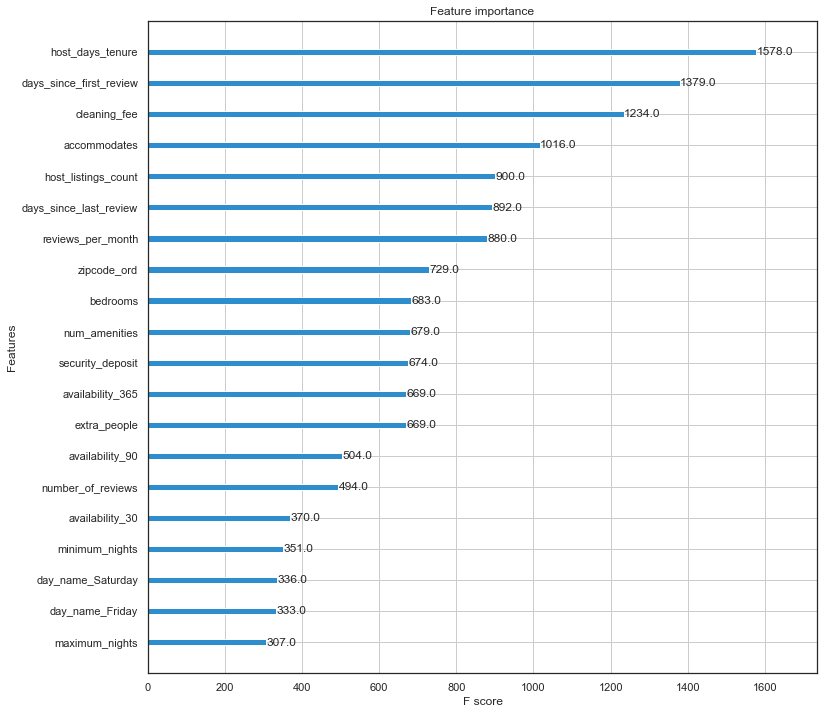

In [146]:
# Feature Importance
fig, ax = plt.subplots(figsize=(12,12))
plot_importance(regressor_3, max_num_features=20, ax=ax, color = '#2e8dcc')
plt.show()

In [147]:
# permutation importance
perm_imp = PermutationImportance(regressor_3, random_state=1).fit(X_test_3, y_test_3)
eli5.show_weights(perm_imp, feature_names = X_test_3.columns.tolist())

Weight,Feature
0.2825 ± 0.0032,bedrooms
0.1486 ± 0.0013,accommodates
0.1172 ± 0.0018,cleaning_fee
0.0378 ± 0.0003,zipcode_ord
0.0331 ± 0.0005,room_type_Entire home/apt
0.0232 ± 0.0001,extra_people
0.0222 ± 0.0004,host_listings_count
0.0206 ± 0.0004,security_deposit
0.0205 ± 0.0002,host_days_tenure
0.0165 ± 0.0003,days_since_last_review


# Question 5: business thinking.


1. Translate the accuracy of the model to a business metric that would incentivise decision-makers at AirBnB to invest more in this model. No code needed, summarize the metric and its importance in a sentence

<div class="alert alert-block alert-info">
    <font color=black>
        <p></p>
        <b>Model 1 - predict listing price given listing details</b>
        <p></p>
        <li>The accuracy of the model represents our ability to forecast listing price. The higher the accuracy, the closer our forecast price will be to the actual price. The actual price could be seen as a proxy of people's <b>Willingness to Pay (WTP)</b>. Therefore, <b>what this model is actually doing is predicting people's WTP</b> based on the listing offering, variation of time and potential other exogenous factors like weather, holiday, macroeconomics, etc.</li>
        <p></p>
        <li>Accurately predict WTP is crucial to optimize our pricing strategy, which determines our <b>Revenue</b> and <b>Profit Margin</b>. Overestimate WTP, i.e. higher pricing than "should be", will reduce demand, lower book rate and hurt our revenue; underestimate WTP, i.e., lower pricing than "should be" will boost demand but hurt our profit margin. So investing this model and increasing accuracy will help the company optimize pricing strategy and increase mid to long term revenue and profit margin. </li>
        <p></p>
        <li>Moreover, people's WTP is constantly changing based on different listing offerings and time. Finding the important features that contributes model accuracy will help the company conduct <b>Root Cause Analysis</b>, eg. identify the key drivers behind a high WTP, thus we can <b>poactively improve our business and operation strategy</b>, such as encouraging better listings descriptions or enabling more super hosts. </li>
    </font>
</div>

<div class="alert alert-block alert-info">
    <font color=black>
        <p></p>
                <b>Model 2 - identify listings with fix price over time (identify low quality listing/low engagement host)</b>
        <p></p>
        Successfully identifying low quality listings or low engagement host can allow the company to proactively manage listing/host qualities and take prescriptive actions to make improvement, which will benefit customer satisfaction and company branding. Therefor, improving this model's performance would drive long term success via <b>increasing book rate, customer net promoter score (cNPS) and eventually company financial performance</b>.
    </font>
</div>